# Karim Kuserbaev

## Funcs

In [189]:
def get_df_low(code: int):
    train_df = pd.read_parquet(f"../data/interim/train_data_lm_{code}.pqt")
    test_df = pd.read_parquet(f"../data/interim/test_data_lm_{code}.pqt")

    cat_cols = [
        "channel_code", "city", "city_type",
        "okved", "segment", "start_cluster",
        "index_city_code", "ogrn_month", "ogrn_year",
    ]

    train_df[cat_cols] = train_df[cat_cols].astype("category")
    test_df[cat_cols] = test_df[cat_cols].astype("category")

    df = pd.concat([train_df, test_df], ignore_index=True)
    return df



def get_feature_description():
  feature_description = pd.read_excel("../data/feature_description.xlsx") # import feature_description to merge description
  feature_description.columns =  ['col_name', 'description', 'type']
  return feature_description



def cat_column_summary(df):
    """Для категорий всех столбцов"""
    df = df.select_dtypes(exclude="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()

        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'distinct_values_counts': distinct_values_counts
        })


    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd

def num_column_summary(df):
    """Для численных всех столбцов"""

    df = df.select_dtypes(include="number")
    summary_data = []

    for col_name in df.columns:
        col_dtype = df[col_name].dtype
        num_of_nulls = df[col_name].isnull().sum()
        num_of_non_nulls = df[col_name].notnull().sum()
        num_of_distinct_values = df[col_name].nunique()
        mean = df[col_name].mean()
        std = df[col_name].std()
        min_val = df[col_name].min()
        q25 = df[col_name].quantile(0.25)
        q50 = df[col_name].quantile(0.50)
        q75 = df[col_name].quantile(0.75)
        max_val = df[col_name].max()


        if num_of_distinct_values <= 10:
            distinct_values_counts = df[col_name].value_counts().to_dict()
        else:
            top_10_values_counts = df[col_name].value_counts().head(10).to_dict()
            distinct_values_counts = {k: v for k, v in sorted(top_10_values_counts.items(), key=lambda item: item[1], reverse=True)}

        summary_data.append({
            'col_name': col_name,
            'col_dtype': col_dtype,
            'num_of_nulls': num_of_nulls,
            'num_of_non_nulls': num_of_non_nulls,
            'num_of_distinct_values': num_of_distinct_values,
            'mean': mean,
            'std': std,
            'min': min_val,
            'q25': q25,
            'q50': q50,
            'q75': q75,
            'max': max_val,
            'distinct_values_counts': distinct_values_counts

        })




    summary_df = pd.DataFrame(summary_data)
    summary_df_with_fd = pd.merge(summary_df, feature_description, on='col_name', suffixes=('_left', '_right'), how='left')

    return summary_df_with_fd
# Пустые значения


def get_nan_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])

  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: x.isna().all()).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', suffixes=('_left', '_right'), how='left')
    end_time = time.time()
  return nan_3_month_df



def process_nan(x):
    try:
        x = x.dropna(
        ).values[-1] if x.isna().any() and not x.isna().all() else np.nan
        return x
    except:
        print(x)
        return x




def get_nan_values_3_month_df(df):

  nan_3_month_df = pd.DataFrame(df['id'].unique(), columns=['id'])
  for column in df.columns[1:]:
    start_time = time.time()
    result = df.groupby('id')[column].apply(
        lambda x: process_nan(x)).reset_index()
    nan_3_month_df = pd.merge(
        nan_3_month_df, result, on='id', how='left')
    end_time = time.time()
    print(f"{column} {end_time - start_time}")
  return nan_3_month_df



def plt_null_df(df):

    plt.figure(figsize=(15, 8))

    plt.imshow(df, aspect="auto", interpolation="nearest", cmap="viridis")

    plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')

    plt.xlabel("Column Number")
    plt.ylabel("Sample Number")

    plt.show()




# Корреляция
def plt_corr_df(df):

  corr_df = df.select_dtypes(include='number').corr().abs()

  plt.figure(figsize=(20, 15))
  dataplot = sns.heatmap(corr_df,
                        cmap="YlGnBu", annot=True, fmt=".1f",
                        annot_kws={'size': 5})
  plt.show()

def get_columns_corr(df, p: int):
    corr_df = df.select_dtypes(include='number').corr().abs()
    c1 = corr_df.unstack()

    c1_sorted = c1.sort_values(ascending=True)
    columns_above = {(col1, col2): c1_sorted[col1, col2] for col1, col2 in c1_sorted.index if c1_sorted[col1, col2] > p and col1 != col2}

    return dict(sorted(columns_above.items(), key=lambda item: item[1], reverse=True))

## Импорт библиотек и настройки

In [64]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [65]:
!pip install catboost

In [278]:
import numpy as np
import pandas as pd
import optuna

from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import os

from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostClassifier, Pool
import catboost
from catboost import *
from catboost import datasets


import numpy as np
import time
import json

import pandas as pd
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_rows', 93)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

import warnings
from sklearn.utils import resample


# Отключить все предупреждения временно
warnings.filterwarnings("ignore")

# Ваш код, вызывающий предупреждение о переполнении

# Включить предупреждения обратно
# warnings.filterwarnings("default")


import matplotlib.pyplot as plt

from sklearn.ensemble import StackingClassifier, RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

In [279]:
!pip freeze | grep "numpy\|pandas\|lightgbm\|scikit-learn"

geopandas==0.14.3
lightgbm @ file:///tmp/lightgbm/lightgbm-4.2.0-py3-none-manylinux_2_31_x86_64.whl#sha256=26ed21477c12bb26edc4d6d51336cd43d5a8f7daf55ebbe27b0faf50ce96db23
numpy @ file:///home/conda/feedstock_root/build_artifacts/numpy_1707225380409/work/dist/numpy-1.26.4-cp310-cp310-linux_x86_64.whl#sha256=51131fd8fc130cd168aecaf1bc0ea85f92e8ffebf211772ceb16ac2e7f10d7ca
pandas==2.1.4
pandas-datareader==0.10.0
pandas-profiling==3.6.6
pandas-summary==0.2.0
pandasql==0.7.3
scikit-learn==1.2.2
scikit-learn-intelex==2024.2.0
sklearn-pandas==2.2.0


In [280]:
pd.options.display.max_rows = 93
pd.options.display.max_columns = 93

## Загрузка данных

In [281]:
df = pd.read_parquet("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/df_restore_cal_avg_start_cluster_3.pqt")
df = pd.read_parquet("/kaggle/input/df-restore-cal-avg-start-cluster-3-pqt/df_restore_cal_avg_start_cluster_3.pqt")

df_org = pd.read_parquet("/kaggle/input/df-for-alfa-hak/df_restore_cat_avg.pqt")

In [282]:
df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,avg_b_oper_3m_month_1,avg_b_oper_3m_month_2,avg_b_oper_3m_month_3,avg_c_oper_1m_month_1,avg_c_oper_1m_month_2,avg_c_oper_1m_month_3,avg_c_oper_3m_month_1,avg_c_oper_3m_month_2,avg_c_oper_3m_month_3,avg_cred_d_oper_1m_month_1,avg_cred_d_oper_1m_month_2,avg_cred_d_oper_1m_month_3,avg_cred_d_oper_3m_month_1,avg_cred_d_oper_3m_month_2,avg_cred_d_oper_3m_month_3,avg_cred_e_oper_1m_month_1,avg_cred_e_oper_1m_month_2,avg_cred_e_oper_1m_month_3,avg_cred_e_oper_3m_month_1,avg_cred_e_oper_3m_month_2,avg_cred_e_oper_3m_month_3,avg_cred_f_oper_1m_month_1,avg_cred_f_oper_1m_month_2,avg_cred_f_oper_1m_month_3,avg_cred_f_oper_3m_month_1,avg_cred_f_oper_3m_month_2,avg_cred_f_oper_3m_month_3,avg_cred_g_oper_1m_month_1,avg_cred_g_oper_1m_month_2,avg_cred_g_oper_1m_month_3,avg_cred_g_oper_3m_month_1,avg_cred_g_oper_3m_month_2,avg_cred_g_oper_3m_month_3,avg_cred_h_oper_1m_month_1,avg_cred_h_oper_1m_month_2,avg_cred_h_oper_1m_month_3,...,cnt_deb_f_oper_3m_month_3,cnt_deb_g_oper_1m_month_1,cnt_deb_g_oper_1m_month_2,cnt_deb_g_oper_1m_month_3,cnt_deb_g_oper_3m_month_1,cnt_deb_g_oper_3m_month_2,cnt_deb_g_oper_3m_month_3,cnt_deb_h_oper_1m_month_1,cnt_deb_h_oper_1m_month_2,cnt_deb_h_oper_1m_month_3,cnt_deb_h_oper_3m_month_1,cnt_deb_h_oper_3m_month_2,cnt_deb_h_oper_3m_month_3,ft_registration_date_month_1,ft_registration_date_month_2,ft_registration_date_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3
0,0,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1246,-0.1246,-0.1246,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,0.5789,0.1088,0.1704,0.5045,0.4758,0.3247,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,0.4415,-0.0957,-0.1334,0.1964,0.1318,0.0355,1.8045,0.6478,0.8779,...,0.2861,0.5139,0.5139,0.5139,0.4581,0.4581,0.4581,0.6541,0.6528,0.6534,0.5536,0.5519,0.5510,2.4522,2.4699,2.4859,-0.4886,-0.4886,-0.4886,-0.1351,-0.1351,-0.1351,ogrn_month_0,ogrn_month_0,ogrn_month_0,ogrn_year_1,ogrn_year_1,ogrn_year_1,okved_30,okved_30,okved_30,segment_1,segment_1,segment_1,"{α, γ}","{α, γ}","{α, γ}",0.5115,0.4864,0.4805,0.9423,0.6457,0.4036,0.5360,0.5364,0.6132
1,1,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1246,-0.1246,-0.1246,-0.2868,-0.2868,-0.1764,-0.2751,-0.2751,-0.2387,0.1295,-0.0411,-0.0101,0.2257,0.0689,0.0312,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,-0.0824,-0.1219,-0.0719,-0.0260,-0.0253,-0.0205,-0.2904,-0.2176,-0.1917,...,0.2861,0.5152,0.5165,0.5152,0.4589,0.4598,0.4598,0.6611,0.6580,0.6617,0.5671,0.5599,0.5608,0.1740,0.1918,0.2078,0.3243,0.3243,0.3243,1.2587,1.2587,1.2587,ogrn_month_5,ogrn_month_5,ogrn_month_5,ogrn_year_15,ogrn_year_15,ogrn_year_15,okved_5,okved_5,okved_5,segment_1,segment_1,segment_1,{other},{other},{other},0.0520,0.0336,0.0395,0.0141,-0.0576,-0.0921,0.0438,0.0350,0.0252
2,2,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1246,-0.1246,-0.1246,0.4713,0.3273,0.8310,0.4467,0.4975,0.5481,-0.1559,-0.1575,-0.1516,-0.1716,-0.1710,-0.1703,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,-0.1334,-0.1334,-0.1334,-0.0303,

In [283]:
cat_names = df.select_dtypes(exclude = 'number').columns

In [284]:

label_encoders = {}
for col in cat_names:
    label_encoders[col] = LabelEncoder().fit(df[col])
    df[col] = label_encoders[col].transform(df[col])

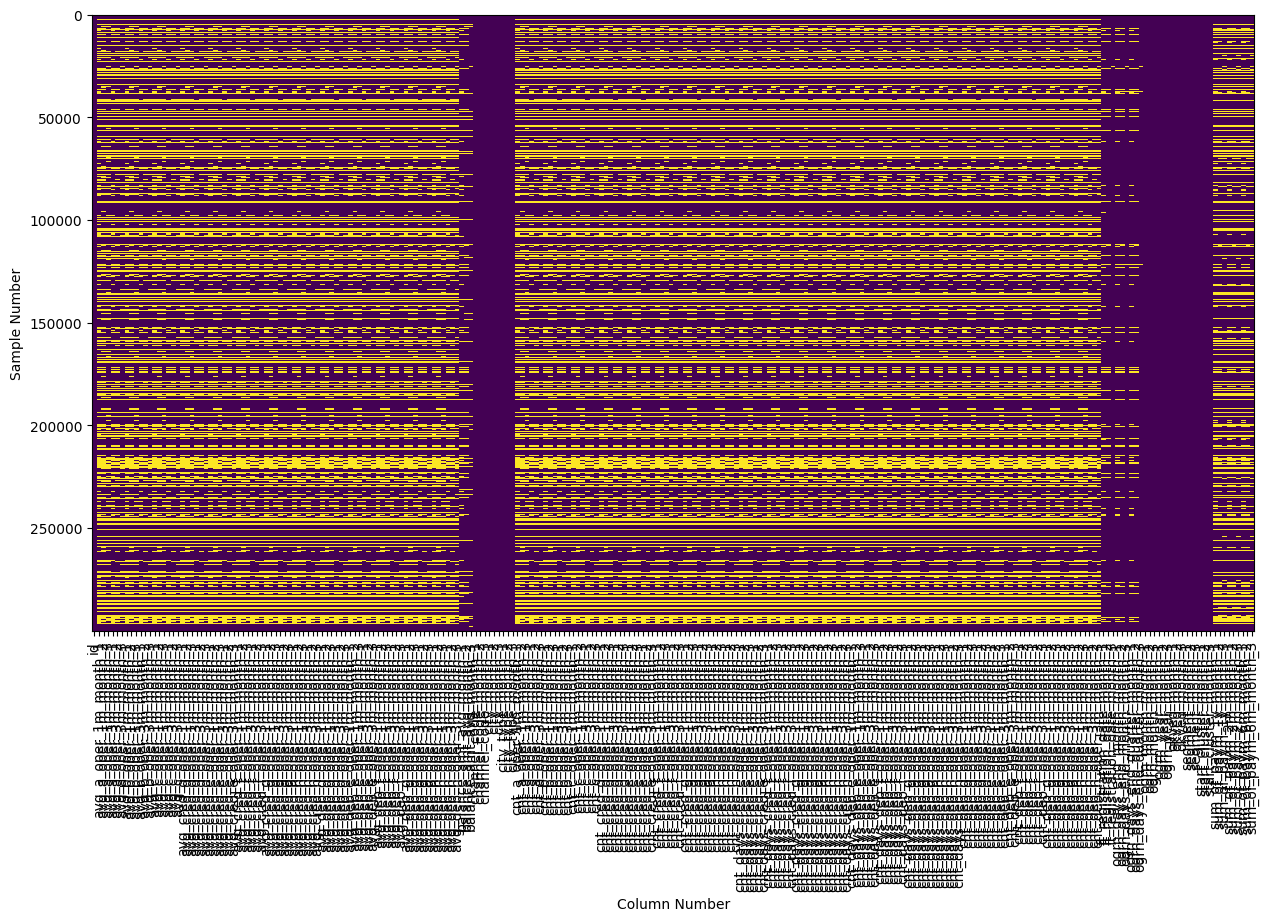

In [285]:
plt_null_df(df.isna())

In [286]:
pivot_df = df_org.pivot_table(index='id', columns='date', aggfunc='first')

# Преобразуем мультииндексные столбцы в одноуровневые
pivot_df.columns = [f'{col[0]}_{col[1]}' for col in pivot_df.columns]

# Объединяем строки для каждого клиента в одну
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.drop(columns = ['end_cluster_month_1', 'end_cluster_month_2'] , axis = 0)

In [287]:
df['end_cluster_month_3'] = pivot_df['end_cluster_month_3']

In [288]:
df['end_cluster_month_3'] = df['end_cluster_month_3'].fillna('missing')

In [289]:
df['end_cluster_month_3']

0         {other}
1         {other}
2             {α}
3          {α, γ}
4             {α}
           ...   
299995    missing
299996    missing
299997    missing
299998    missing
299999    missing
Name: end_cluster_month_3, Length: 300000, dtype: object

In [290]:
train_df = df[df['id']< 200000]
test_df = df[df['id'] >= 200000]

Обозначение категориальных признаков

In [235]:
cat_names = list(df.select_dtypes(exclude= 'number').columns)

In [236]:
cat_names

['end_cluster_month_3']

In [237]:

# label_encoders = {}

# for col in cat_names:
#     print(col)
#     label_encoders[col] = LabelEncoder().fit(pivot_df[col])

#     train_df[col] = label_encoders[col].transform(train_df[col])
#     test_df[col] = label_encoders[col].transform(test_df[col])

In [238]:
df[df.duplicated(subset=df.columns.difference(['id']), keep=False) & (df['id'] < 199999)].T

,1515,1996,2839,2869,3196,3491,4394,5744,6654,7248,10794,10878,10954,12239,12928,13669,14775,15187,15339,16321,16488,16756,16944,17404,18667,18743,18888,19267,19309,20159,20566,20936,22161,23365,24220,25104,25289,26641,26751,27083,28454,28899,29424,30647,32121,35440,...,102755,104555,106262,106521,107042,122609,123777,124581,125501,126419,126462,132940,135675,137337,140302,143008,143946,147857,150655,153807,154470,156536,162586,162947,164134,164797,175251,175661,176751,178367,181698,183871,186125,187954,189304,191174,191824,191990,192282,194793,196352,196489,196742,197159,197351,197750
id,1515,1996,2839,2869,3196,3491,4394,5744,6654,7248,10794,10878,10954,12239,12928,13669,14775,15187,15339,16321,16488,16756,16944,17404,18667,18743,18888,19267,19309,20159,20566,20936,22161,23365,24220,25104,25289,26641,26751,27083,28454,28899,29424,30647,32121,35440,...,102755,104555,106262,106521,107042,122609,123777,124581,125501,126419,126462,132940,135675,137337,140302,143008,143946,147857,150655,153807,154470,156536,162586,162947,164134,164797,175251,175661,176751,178367,181698,183871,186125,187954,189304,191174,191824,191990,192282,194793,196352,196489,196742,197159,197351,197750
avg_a_oper_1m_month_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,...,NaN,NaN,-0.4528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avg_a_oper_1m_month_2,-0.4528,-0.4528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.4528,NaN,NaN,-0.4528,NaN,NaN,-0.4528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN
avg_a_oper_1m_month_3,NaN,-0.4528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4359,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,-0.4528,-0.4528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,...,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,-0.4528,-0.4528,NaN,NaN,-0.4528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.4528,NaN,NaN,NaN
avg_a_oper_3m_month_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.9934,NaN,...,NaN,NaN,-0.9934,-0.9934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.9934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
sum_of_paym_2m_month_3,-0.2738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.2740,NaN,-0.2738,NaN,NaN,NaN,NaN,NaN,-0.2691,NaN,NaN,NaN,-0.2739,-0.2739,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.2738,-0.2691,NaN,-0.2740,NaN,...,NaN,NaN,-0.2740,NaN,NaN,NaN,-0.2738,NaN,NaN,-0.2739,NaN,NaN,NaN,-0.2739,NaN,NaN,NaN,NaN,-0.2739,NaN,NaN,-0.2691,NaN,-0.2738,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sum_of_paym_6m_month_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.2946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.2946,NaN,...,NaN,NaN,-0.2946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [535]:
bad_clients_ids = np.unique(df[(df.drop(labels=["id"], axis=1).duplicated() == True) &  (df['id'] < 199999)]['id'].values)
print(f"{bad_clients_ids} - len =  {len(bad_clients_ids)}")

[  4394  24220  26641  28899  29424  35440  41876  45037  46427  48717
  50893  54240  55042  55103  62728  63353  65785  66656  67733  69341
  69504  70271  70540  70990  74694  76441  78484  81991  83300  84579
  85481  85999  87029  87922  87924  87954  88290  90321  90680  91344
  91788  92268  92307  92708  94182  94348  99694 100271 102755 106262
 124581 125501 126419 126462 132940 135675 137337 140302 143008 143946
 147857 150655 153807 154470 156536 162947 164134 175251 175661 176751
 178367 181698 183871 186125 187954 189304 191174 191824 191990 192282
 194793 196352 196489 196742 197159 197351 197750] - len =  87


In [536]:
df = df[~df['id'].isin(bad_clients_ids)]
df.shape

(299913, 251)

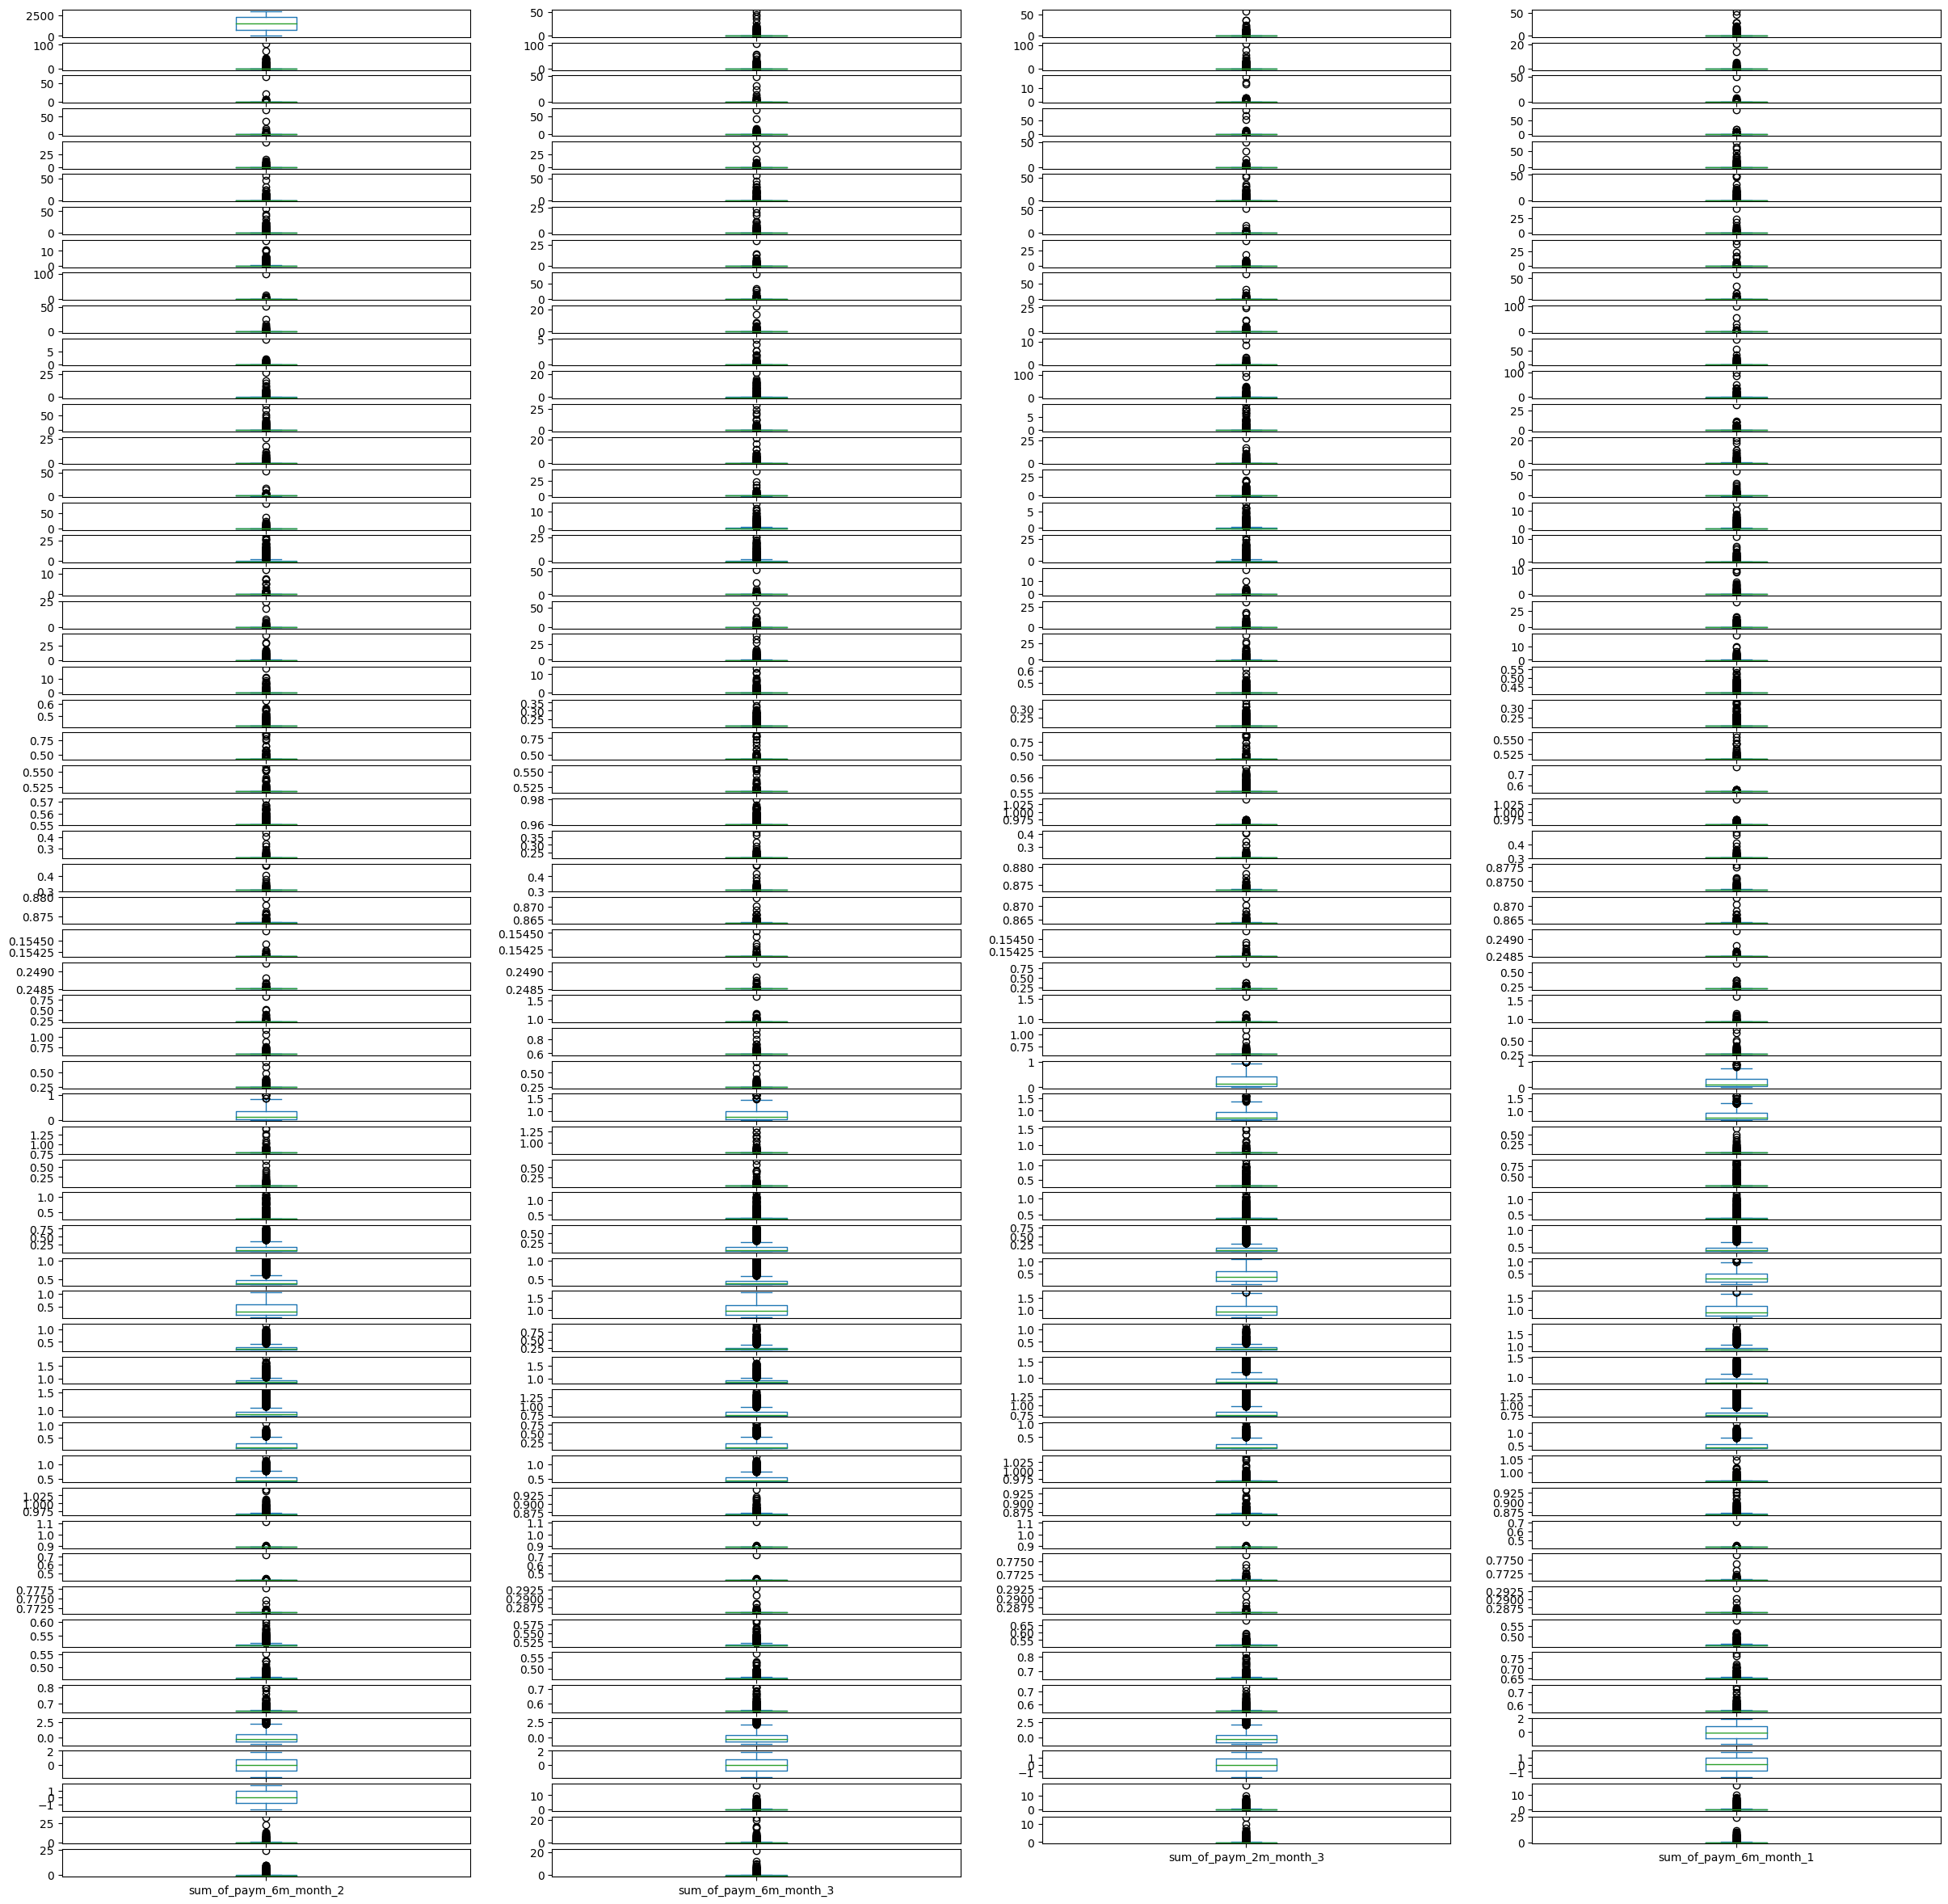

In [537]:
df[df.select_dtypes(include='number').columns][:3000].plot(kind='box', subplots=True, layout=(-1, 4),
                                                           figsize=(30, 30))

plt.show()

In [538]:
def remove_outliers(df, k=4):
    # Создаем копию DataFrame, чтобы избежать изменения исходного DataFrame
    df_cleaned = df.copy()

    # Итерируемся по каждому числовому столбцу
    for column in df_cleaned.select_dtypes(include='number').columns:
        # Вычисляем квартили
        Q1 = df_cleaned[column].quantile(0.25)
        Q3 = df_cleaned[column].quantile(0.75)

        # Вычисляем межквартильный размах (IQR)
        IQR = Q3 - Q1

        # Определяем верхнюю и нижнюю границы для выбросов
        lower_bound = Q1 - k * IQR
        upper_bound = Q3 + k * IQR

        # Заменяем значения за пределами границ на минимальное и максимальное значение
        df_cleaned[column] = df_cleaned[column].clip(
            lower=lower_bound, upper=upper_bound)

    return df_cleaned


# Применяем функцию к DataFrame, чтобы избавиться от выбросов
df = remove_outliers(df)

### Создаем каждого клиента со всеми его признаками

### Создаем выборки для валидации и обучения

Деление на обучающую и тестовую, исправляем дизбаланс классов, если не требуется, пропустить эти блоки до следующего текста

In [291]:
train_df = df[df['id']< 200000]
test_df = df[df['id'] >= 200000]

In [292]:
X = train_df.drop(["id"], axis=1) # оставляю end_cluster чтобы получить пропорцию классов, а потом ниже удалю в коде
y = train_df["end_cluster_month_3"]


In [293]:
x_train, x_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=42)

In [294]:
x_train['end_cluster_month_3'].value_counts().median()

1432.0

In [360]:
# Определение желаемого количества экземпляров каждого класса
desired_class_count = 40000  # Укажите ваше желаемое количество экземпляров

# Обработка дисбаланса классов
balanced_data = pd.DataFrame()
for cluster in x_train['end_cluster_month_3'].unique():
    cluster_data = x_train[x_train['end_cluster_month_3'] == cluster]
    if len(cluster_data) < desired_class_count:
        resampled_data = resample(
            cluster_data, replace=True, n_samples=desired_class_count, random_state=42)
    else:
        resampled_data = cluster_data.sample(
            n=desired_class_count, replace=False, random_state=42)
    balanced_data = pd.concat([balanced_data, resampled_data])

In [299]:
desired_class_counts = {
    '{α, β}': 3000,        # Желаемое количество экземпляров для класса α, β
    '{α, θ}': 2000,        # Желаемое количество экземпляров для класса α, θ
    '{α, ε}': 2000,        # Желаемое количество экземпляров для класса α, ε
    '{α, δ}': 2000,        # Желаемое количество экземпляров для класса α, δ
    '{α, ψ}': 1000,        # Желаемое количество экземпляров для класса α, ψ
    '{α, μ}': 1000,        # Желаемое количество экземпляров для класса α, μ
    '{α, ε, η}': 1000,     # Желаемое количество экземпляров для класса α, ε, η
    '{α, ε, θ}': 1000,     # Желаемое количество экземпляров для класса α, ε, θ
    '{α, λ}': 1000,        # Желаемое количество экземпляров для класса α, λ
    '{α, ε, ψ}': 500,     # Желаемое количество экземпляров для класса α, ε, ψ
    '{λ}': 500,           # Желаемое количество экземпляров для класса λ
    '{α, π}': 100         # Желаемое количество экземпляров для класса α, π
    # Добавьте другие классы и их желаемое количество экземпляров
}

balanced_data = pd.DataFrame()
for cluster in x_train['end_cluster_month_3'].unique():
    cluster_data = x_train[x_train['end_cluster_month_3'] == cluster]
    desired_count = desired_class_counts.get(cluster)
    if desired_count is None:
        # Если для данного класса нет указанного желаемого количества, оставить данные без изменений
        balanced_data = pd.concat([balanced_data, cluster_data])
    else:
        if len(cluster_data) < desired_count:
            resampled_data = resample(
                cluster_data, replace=True, n_samples=desired_count, random_state=42)
        else:
            resampled_data = cluster_data.sample(
                n=desired_count, replace=False, random_state=42)
        balanced_data = pd.concat([balanced_data, resampled_data])



In [300]:
balanced_data['end_cluster_month_3'].value_counts()

end_cluster_month_3
{α}          84479
{}           33282
{other}      13280
{α, η}       10016
{α, γ}        9022
{α, β}        3000
{α, θ}        2000
{α, δ}        2000
{α, ε}        2000
{α, μ}        1000
{α, ε, θ}     1000
{α, ε, η}     1000
{α, ψ}        1000
{α, λ}        1000
{α, ε, ψ}      500
{λ}            500
{α, π}         100
Name: count, dtype: int64

In [301]:
x_train = balanced_data

In [243]:
# Calculate current class proportions
class_proportions = x_train['end_cluster_month_3'].value_counts(normalize=True)

# Identify underrepresented classes
underrepresented_classes = class_proportions[class_proportions < 0.02].index

# Create an empty list to store additional rows
additional_rows = []

# Calculate the number of additional rows needed for each underrepresented class
for class_label in underrepresented_classes:
    current_proportion = class_proportions[class_label]
    desired_proportion = 0.02
    current_count = (x_train['end_cluster_month_3'] == class_label).sum()
    desired_count = int(desired_proportion * len(train_df))
    additional_count = desired_count - current_count

    if additional_count > 0:
        additional_samples = x_train[x_train['end_cluster_month_3'] == class_label].sample(n=additional_count, replace=True)
        additional_rows.append(additional_samples)

# Concatenate additional rows with the original dataframe
if additional_rows:
    x_train = pd.concat([x_train] + additional_rows, ignore_index=True)

# Verify the class proportions after balancing
print(x_train['end_cluster_month_3'].value_counts())


end_cluster_month_3
{α}          84479
{}           33282
{other}      13280
{α, η}       10016
{α, γ}        9022
{α, β}        4000
{α, θ}        4000
{α, δ}        4000
{α, μ}        4000
{α, ε}        4000
{α, ε, θ}     4000
{α, ε, η}     4000
{α, ψ}        4000
{α, ε, ψ}     4000
{λ}           4000
{α, λ}        4000
{α, π}        4000
Name: count, dtype: int64


In [302]:
x_train['end_cluster_month_3'].value_counts()

end_cluster_month_3
{α}          84479
{}           33282
{other}      13280
{α, η}       10016
{α, γ}        9022
{α, β}        3000
{α, θ}        2000
{α, δ}        2000
{α, ε}        2000
{α, μ}        1000
{α, ε, θ}     1000
{α, ε, η}     1000
{α, ψ}        1000
{α, λ}        1000
{α, ε, ψ}      500
{λ}            500
{α, π}         100
Name: count, dtype: int64

In [303]:
y = X['end_cluster_month_3']
X = X.drop(['end_cluster_month_3'], axis=1)
x_val = x_val.drop(['end_cluster_month_3'], axis=1)

In [304]:
y_train = x_train['end_cluster_month_3']
x_train = x_train.drop(['end_cluster_month_3'], axis=1)
x_val = x_val.drop(['end_cluster_month_3'], axis=1)

KeyError: "['end_cluster_month_3'] not found in axis"

In [305]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((165179, 249), (165179,), (40000, 249), (40000,))

In [306]:
X.shape, y.shape, x_val.shape, y_val.shape

((200000, 249), (200000,), (40000, 249), (40000,))

In [223]:
X['end_cluster_month_3'].value_counts()

end_cluster_month_3
{α}          105884
{}            40770
{other}       16661
{α, η}        13066
{α, γ}        11136
{α, β}         3706
{α, θ}         2170
{α, ε}         1819
{α, δ}         1767
{α, ψ}          926
{α, μ}          716
{α, ε, η}       548
{α, ε, θ}       373
{α, λ}          293
{α, ε, ψ}       111
{λ}              49
{α, π}            5
Name: count, dtype: int64

Деление на тестовую и обучающую выборку без дизбаланса

In [597]:
# X = train_df.drop(["id", "date", "end_cluster"], axis=1)
# y = train_df["end_cluster"]

# x_train, x_val, y_train, y_val = train_test_split(X, y,
#                                                   test_size=0.2,
#                                                   random_state=42)

## Обучение модели

Кросс-валидация для CatBoost (не нажимать если не разбираешься). Если не разбираешься, идти к следующему блоку текста

In [96]:
cat_names = X.select_dtypes(exclude = 'number').columns

In [97]:
cat_names

Index([], dtype='object')

In [247]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [248]:
cluster_weights = pd.read_excel("/kaggle/input/alfa-hak1/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

In [249]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier

def objective(trial):
    # Определите гиперпараметры, которые вы хотите оптимизировать
    params = {
        'iterations': trial.suggest_int('iterations', 50, 2000, step=50),
        'depth': trial.suggest_int('depth', 4, 10, step=1),
        'learning_rate': trial.suggest_categorical('learning_rate', np.linspace(0.01, 0.1, 10)),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 0, 10),
    }
    
    catboost = CatBoostClassifier(loss_function='MultiClass', early_stopping_rounds=20, task_type="GPU", random_seed=42, **params)
    
    catboost.fit(
        x_train, y_train,
        eval_set=(x_val, y_val),
        verbose=500  # выводить стату через каждые 15 итераций
    )
    
    y_pred_proba = catboost.predict_proba(x_val)
    return weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)


study = optuna.create_study(direction='maximize')

study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = study.best_value

print("Best parameters found: ", best_params)
print("Best score: ", best_score)


[I 2024-04-14 09:20:38,424] A new study created in memory with name: no-name-25023d6c-b478-4c1b-81c7-dce0a6627019


0:	learn: 2.3668524	test: 2.2323457	best: 2.2323457 (0)	total: 92.7ms	remaining: 32.3s


[W 2024-04-14 09:20:42,432] Trial 0 failed with parameters: {'iterations': 350, 'depth': 6, 'learning_rate': 0.09000000000000001, 'l2_leaf_reg': 8} because of the following error: KeyboardInterrupt('').
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_34/1936499183.py", line 17, in objective
    catboost.fit(
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 5201, in fit
    self._fit(X, y, cat_features, text_features, embedding_features, None, sample_weight, None, None, None, None, baseline, use_best_model,
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 2396, in _fit
    self._train(
  File "/opt/conda/lib/python3.10/site-packages/catboost/core.py", line 1776, in _train
    self._object._train(train_pool, test_pool, params, allow_clear_pool, init_model._object if init_model else None)
  File "_catb

KeyboardInterrupt: 

In [136]:
import optuna
import numpy as np
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define your data x_train, x_val, y_train, y_val
# Replace them with your actual data
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 50, 2000, step=50),
        'depth': trial.suggest_int('depth', 4, 10, step=1),
        'learning_rate': trial.suggest_categorical('learning_rate', np.linspace(0.01, 0.1, 10)),
        'l2_leaf_reg': trial.suggest_int('l2_leaf_reg', 0, 10),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bayesian']),  # Removed 'MVS'
        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 16),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 20),
        'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 1, 10),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'random_strength': trial.suggest_float('random_strength', 0.1, 1.0, step=0.1)
    }
    
    if params['bootstrap_type'] == 'Bayesian':
        # Remove 'subsample' parameter if 'bootstrap_type' is 'Bayesian'
        params.pop('subsample', None)
    
    catboost = CatBoostClassifier(loss_function='MultiClass', early_stopping_rounds=20, random_seed=42, task_type="GPU", **params)
    
    catboost.fit(
        x_train, y_train,
        eval_set=(x_val, y_val),
        verbose=500  # выводить статус через каждые 500 итераций
    )
    
    y_pred = catboost.predict(x_val)
    return accuracy_score(y_val, y_pred)


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = study.best_value

print("Best parameters found: ", best_params)
print("Best score: ", best_score)


[I 2024-04-14 02:11:41,177] A new study created in memory with name: no-name-10750355-881c-4fc0-adf2-1fdddcb6aa32


0:	learn: 2.6828363	test: 2.6748748	best: 2.6748748 (0)	total: 309ms	remaining: 2m 18s
449:	learn: 0.6725129	test: 0.7844276	best: 0.7844276 (449)	total: 1m 43s	remaining: 0us
bestTest = 0.7844276367
bestIteration = 449


[I 2024-04-14 02:13:27,177] Trial 0 finished with value: 0.74445 and parameters: {'iterations': 450, 'depth': 10, 'learning_rate': 0.05000000000000001, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 2, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 5, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.7000000000000001}. Best is trial 0 with value: 0.74445.


0:	learn: 2.7754848	test: 2.7721453	best: 2.7721453 (0)	total: 163ms	remaining: 8s
49:	learn: 1.3220449	test: 1.2384202	best: 1.2384202 (49)	total: 8.36s	remaining: 0us
bestTest = 1.238420215
bestIteration = 49


[I 2024-04-14 02:13:37,166] Trial 1 finished with value: 0.735025 and parameters: {'iterations': 50, 'depth': 10, 'learning_rate': 0.020000000000000004, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 9, 'leaf_estimation_iterations': 16, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 0 with value: 0.74445.


0:	learn: 2.7414828	test: 2.7340781	best: 2.7340781 (0)	total: 62.5ms	remaining: 18.7s
299:	learn: 0.8991770	test: 0.8280436	best: 0.8280436 (299)	total: 21.6s	remaining: 0us
bestTest = 0.8280435547
bestIteration = 299


[I 2024-04-14 02:14:00,581] Trial 2 finished with value: 0.740325 and parameters: {'iterations': 300, 'depth': 8, 'learning_rate': 0.05000000000000001, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 5, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 0 with value: 0.74445.


0:	learn: 2.7973764	test: 2.7946660	best: 2.7946660 (0)	total: 32.6ms	remaining: 24.4s
500:	learn: 0.9607596	test: 0.8684965	best: 0.8684965 (500)	total: 15.9s	remaining: 7.93s
749:	learn: 0.9276725	test: 0.8404449	best: 0.8404449 (749)	total: 24s	remaining: 0us
bestTest = 0.8404449219
bestIteration = 749


[I 2024-04-14 02:14:26,481] Trial 3 finished with value: 0.7402 and parameters: {'iterations': 750, 'depth': 6, 'learning_rate': 0.020000000000000004, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 11, 'leaf_estimation_iterations': 5, 'max_ctr_complexity': 3, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.1}. Best is trial 0 with value: 0.74445.


0:	learn: 2.7617359	test: 2.7559563	best: 2.7559563 (0)	total: 18.2ms	remaining: 20.9s
500:	learn: 0.9430153	test: 0.8519600	best: 0.8519600 (500)	total: 8.25s	remaining: 10.7s
1000:	learn: 0.9035472	test: 0.8188430	best: 0.8188430 (1000)	total: 16.2s	remaining: 2.41s
1149:	learn: 0.8977186	test: 0.8143534	best: 0.8143534 (1149)	total: 18.5s	remaining: 0us
bestTest = 0.814353418
bestIteration = 1149


[I 2024-04-14 02:14:46,904] Trial 4 finished with value: 0.7429 and parameters: {'iterations': 1150, 'depth': 4, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 15, 'leaf_estimation_iterations': 3, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 0 with value: 0.74445.


0:	learn: 2.7507746	test: 2.7466887	best: 2.7466887 (0)	total: 22.8ms	remaining: 41s
500:	learn: 0.9165208	test: 0.8320331	best: 0.8320331 (500)	total: 10.5s	remaining: 27.1s
1000:	learn: 0.8833291	test: 0.8029652	best: 0.8029652 (1000)	total: 20.4s	remaining: 16.3s
1500:	learn: 0.8678172	test: 0.7927271	best: 0.7927271 (1500)	total: 30.6s	remaining: 6.09s
1799:	learn: 0.8607854	test: 0.7889111	best: 0.7889111 (1799)	total: 36.9s	remaining: 0us
bestTest = 0.7889111328
bestIteration = 1799


[I 2024-04-14 02:15:25,955] Trial 5 finished with value: 0.74315 and parameters: {'iterations': 1800, 'depth': 4, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.1}. Best is trial 0 with value: 0.74445.


0:	learn: 2.6230291	test: 2.6078199	best: 2.6078199 (0)	total: 245ms	remaining: 7m 21s
500:	learn: 0.6139619	test: 0.7880944	best: 0.7880944 (500)	total: 1m 48s	remaining: 4m 40s
bestTest = 0.7862139648
bestIteration = 620
Shrink model to first 621 iterations.


[I 2024-04-14 02:17:48,736] Trial 6 finished with value: 0.74355 and parameters: {'iterations': 1800, 'depth': 10, 'learning_rate': 0.09000000000000001, 'l2_leaf_reg': 0, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 8, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.7000000000000001}. Best is trial 0 with value: 0.74445.


0:	learn: 2.5751453	test: 2.5612520	best: 2.5612520 (0)	total: 83ms	remaining: 12.4s
149:	learn: 0.8440105	test: 0.7982299	best: 0.7982299 (149)	total: 11.6s	remaining: 0us
bestTest = 0.7982298828
bestIteration = 149


[I 2024-04-14 02:18:02,046] Trial 7 finished with value: 0.74275 and parameters: {'iterations': 150, 'depth': 8, 'learning_rate': 0.09000000000000001, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 7, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 5, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 0 with value: 0.74445.


0:	learn: 2.3843318	test: 2.3418826	best: 2.3418826 (0)	total: 49.2ms	remaining: 36.8s
500:	learn: 0.7651385	test: 0.7715274	best: 0.7715274 (500)	total: 36.3s	remaining: 18s
bestTest = 0.7707746094
bestIteration = 568
Shrink model to first 569 iterations.


[I 2024-04-14 02:18:46,502] Trial 8 finished with value: 0.74485 and parameters: {'iterations': 750, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 2, 'leaf_estimation_iterations': 7, 'max_ctr_complexity': 7, 'leaf_estimation_method': 'Newton', 'random_strength': 0.8}. Best is trial 8 with value: 0.74485.


0:	learn: 2.5406000	test: 2.4760145	best: 2.4760145 (0)	total: 182ms	remaining: 2m 53s
500:	learn: 0.9067874	test: 0.8224635	best: 0.8224635 (500)	total: 1m 56s	remaining: 1m 44s
949:	learn: 0.8719232	test: 0.8081629	best: 0.8081605 (947)	total: 3m 47s	remaining: 0us
bestTest = 0.8081605469
bestIteration = 947
Shrink model to first 948 iterations.


[I 2024-04-14 02:22:36,197] Trial 9 finished with value: 0.74135 and parameters: {'iterations': 950, 'depth': 10, 'learning_rate': 0.08, 'l2_leaf_reg': 0, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 7, 'leaf_estimation_iterations': 5, 'max_ctr_complexity': 7, 'leaf_estimation_method': 'Newton', 'random_strength': 0.8}. Best is trial 8 with value: 0.74485.


0:	learn: 2.7751139	test: 2.7727145	best: 2.7727145 (0)	total: 70.8ms	remaining: 1m 39s
500:	learn: 0.8998104	test: 0.8189310	best: 0.8189310 (500)	total: 32.9s	remaining: 59.1s
1000:	learn: 0.8578369	test: 0.7918426	best: 0.7918426 (1000)	total: 1m 6s	remaining: 26.4s
1399:	learn: 0.8387340	test: 0.7834608	best: 0.7834608 (1399)	total: 1m 32s	remaining: 0us
bestTest = 0.7834608398
bestIteration = 1399


[I 2024-04-14 02:24:11,182] Trial 10 finished with value: 0.743725 and parameters: {'iterations': 1400, 'depth': 6, 'learning_rate': 0.01, 'l2_leaf_reg': 7, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 2, 'leaf_estimation_iterations': 13, 'max_ctr_complexity': 1, 'leaf_estimation_method': 'Newton', 'random_strength': 1.0}. Best is trial 8 with value: 0.74485.


0:	learn: 2.4739309	test: 2.4557594	best: 2.4557594 (0)	total: 118ms	remaining: 58.9s
bestTest = 0.773378125
bestIteration = 455
Shrink model to first 456 iterations.


[I 2024-04-14 02:25:15,470] Trial 11 finished with value: 0.74515 and parameters: {'iterations': 500, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 7, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 2, 'leaf_estimation_iterations': 10, 'max_ctr_complexity': 5, 'leaf_estimation_method': 'Newton', 'random_strength': 0.9}. Best is trial 11 with value: 0.74515.


0:	learn: 2.4739307	test: 2.4557594	best: 2.4557594 (0)	total: 74.4ms	remaining: 55.8s
bestTest = 0.7738543945
bestIteration = 444
Shrink model to first 445 iterations.


[I 2024-04-14 02:26:20,285] Trial 12 finished with value: 0.74565 and parameters: {'iterations': 750, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 7, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 4, 'leaf_estimation_iterations': 11, 'max_ctr_complexity': 6, 'leaf_estimation_method': 'Newton', 'random_strength': 1.0}. Best is trial 12 with value: 0.74565.


0:	learn: 2.4873188	test: 2.4729758	best: 2.4729758 (0)	total: 77.9ms	remaining: 46.7s
bestTest = 0.7746677246
bestIteration = 401
Shrink model to first 402 iterations.


[I 2024-04-14 02:27:21,661] Trial 13 finished with value: 0.7455 and parameters: {'iterations': 600, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 5, 'leaf_estimation_iterations': 12, 'max_ctr_complexity': 4, 'leaf_estimation_method': 'Newton', 'random_strength': 1.0}. Best is trial 12 with value: 0.74565.


0:	learn: 2.5621168	test: 2.5595137	best: 2.5595137 (0)	total: 123ms	remaining: 2m 39s
bestTest = 0.7789283691
bestIteration = 266
Shrink model to first 267 iterations.


[I 2024-04-14 02:28:35,027] Trial 14 finished with value: 0.74565 and parameters: {'iterations': 1300, 'depth': 9, 'learning_rate': 0.07, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 5, 'leaf_estimation_iterations': 13, 'max_ctr_complexity': 3, 'leaf_estimation_method': 'Newton', 'random_strength': 1.0}. Best is trial 12 with value: 0.74565.


0:	learn: 2.4502180	test: 2.4237309	best: 2.4237309 (0)	total: 125ms	remaining: 2m 48s
bestTest = 0.781665332
bestIteration = 238
Shrink model to first 239 iterations.


[I 2024-04-14 02:29:43,472] Trial 15 finished with value: 0.744025 and parameters: {'iterations': 1350, 'depth': 9, 'learning_rate': 0.07, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 5, 'leaf_estimation_iterations': 14, 'max_ctr_complexity': 2, 'leaf_estimation_method': 'Newton', 'random_strength': 0.4}. Best is trial 12 with value: 0.74565.


0:	learn: 2.5787916	test: 2.5748121	best: 2.5748121 (0)	total: 123ms	remaining: 3m 10s
bestTest = 0.7763246582
bestIteration = 286
Shrink model to first 287 iterations.


[I 2024-04-14 02:30:55,607] Trial 16 finished with value: 0.744725 and parameters: {'iterations': 1550, 'depth': 9, 'learning_rate': 0.07, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 5, 'leaf_estimation_iterations': 11, 'max_ctr_complexity': 3, 'leaf_estimation_method': 'Newton', 'random_strength': 1.0}. Best is trial 12 with value: 0.74565.


0:	learn: 2.6551039	test: 2.6515508	best: 2.6515508 (0)	total: 57.2ms	remaining: 1m
500:	learn: 0.7795238	test: 0.7742104	best: 0.7741922 (499)	total: 51s	remaining: 55.9s
bestTest = 0.7725356445
bestIteration = 632
Shrink model to first 633 iterations.


[I 2024-04-14 02:32:04,140] Trial 17 finished with value: 0.746175 and parameters: {'iterations': 1050, 'depth': 7, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 4, 'leaf_estimation_iterations': 15, 'max_ctr_complexity': 7, 'leaf_estimation_method': 'Newton', 'random_strength': 0.9}. Best is trial 17 with value: 0.746175.


0:	learn: 2.6741455	test: 2.6732691	best: 2.6732691 (0)	total: 43.9ms	remaining: 41.7s
500:	learn: 0.8120616	test: 0.7773954	best: 0.7773872 (499)	total: 36.3s	remaining: 32.6s
949:	learn: 0.7618942	test: 0.7724048	best: 0.7724048 (949)	total: 1m 9s	remaining: 0us
bestTest = 0.7724047852
bestIteration = 949


[I 2024-04-14 02:33:15,616] Trial 18 finished with value: 0.7455 and parameters: {'iterations': 950, 'depth': 6, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 7, 'leaf_estimation_iterations': 16, 'max_ctr_complexity': 7, 'leaf_estimation_method': 'Newton', 'random_strength': 0.8}. Best is trial 17 with value: 0.746175.


0:	learn: 2.6038359	test: 2.5946754	best: 2.5946754 (0)	total: 53.8ms	remaining: 59.1s
500:	learn: 0.7904245	test: 0.7736320	best: 0.7736320 (500)	total: 39.6s	remaining: 47.4s
bestTest = 0.7694238281
bestIteration = 943
Shrink model to first 944 iterations.


[I 2024-04-14 02:34:34,321] Trial 19 finished with value: 0.745925 and parameters: {'iterations': 1100, 'depth': 7, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 4, 'leaf_estimation_iterations': 9, 'max_ctr_complexity': 6, 'leaf_estimation_method': 'Newton', 'random_strength': 0.9}. Best is trial 17 with value: 0.746175.


0:	learn: 2.5350094	test: 2.5095436	best: 2.5095436 (0)	total: 30.3ms	remaining: 33.3s
1000:	learn: 0.7939729	test: 0.7711113	best: 0.7711113 (1000)	total: 44s	remaining: 26.3s
1500:	learn: 0.7635966	test: 0.7684651	best: 0.7684443 (1497)	total: 1m 5s	remaining: 4.35s
1599:	learn: 0.7574640	test: 0.7682518	best: 0.7682483 (1597)	total: 1m 10s	remaining: 0us
bestTest = 0.7682483398
bestIteration = 1597
Shrink model to first 1598 iterations.


[I 2024-04-14 02:37:19,869] Trial 22 finished with value: 0.746825 and parameters: {'iterations': 1600, 'depth': 7, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 12, 'leaf_estimation_iterations': 1, 'max_ctr_complexity': 6, 'leaf_estimation_method': 'Newton', 'random_strength': 0.5}. Best is trial 22 with value: 0.746825.


0:	learn: 2.1219285	test: 2.0596711	best: 2.0596711 (0)	total: 47.7ms	remaining: 1m 20s
500:	learn: 0.8225387	test: 0.7742236	best: 0.7742236 (500)	total: 11.1s	remaining: 26.6s
bestTest = 0.770433252
bestIteration = 906
Shrink model to first 907 iterations.


[I 2024-04-14 02:37:42,162] Trial 23 finished with value: 0.7445 and parameters: {'iterations': 1700, 'depth': 5, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 12, 'leaf_estimation_iterations': 1, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Newton', 'random_strength': 0.30000000000000004}. Best is trial 22 with value: 0.746825.


0:	learn: 2.5347180	test: 2.5092559	best: 2.5092559 (0)	total: 28.7ms	remaining: 44.5s
500:	learn: 0.8537494	test: 0.7849185	best: 0.7849129 (499)	total: 13.6s	remaining: 28.5s
1000:	learn: 0.8241551	test: 0.7742807	best: 0.7742807 (1000)	total: 26.5s	remaining: 14.5s
1500:	learn: 0.8032683	test: 0.7707275	best: 0.7707181 (1497)	total: 39.9s	remaining: 1.3s
1549:	learn: 0.8013507	test: 0.7704542	best: 0.7704448 (1548)	total: 41.2s	remaining: 0us
bestTest = 0.7704448242
bestIteration = 1548
Shrink model to first 1549 iterations.


[I 2024-04-14 02:38:25,599] Trial 24 finished with value: 0.74535 and parameters: {'iterations': 1550, 'depth': 5, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 12, 'leaf_estimation_iterations': 2, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Newton', 'random_strength': 0.5}. Best is trial 22 with value: 0.746825.


0:	learn: 2.5278520	test: 2.4995498	best: 2.4995498 (0)	total: 81.2ms	remaining: 2m 5s
500:	learn: 0.7919965	test: 0.7741758	best: 0.7741758 (500)	total: 35.8s	remaining: 1m 14s
bestTest = 0.7697782715
bestIteration = 895
Shrink model to first 896 iterations.


[I 2024-04-14 02:39:33,221] Trial 25 finished with value: 0.745525 and parameters: {'iterations': 1550, 'depth': 7, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 7, 'max_ctr_complexity': 6, 'leaf_estimation_method': 'Newton', 'random_strength': 0.5}. Best is trial 22 with value: 0.746825.


0:	learn: 2.5291641	test: 2.5034875	best: 2.5034875 (0)	total: 34.9ms	remaining: 1m 8s
500:	learn: 0.8218260	test: 0.7777750	best: 0.7777565 (499)	total: 20.5s	remaining: 59.2s
1000:	learn: 0.7728329	test: 0.7711700	best: 0.7711532 (998)	total: 41.5s	remaining: 39.4s
bestTest = 0.7706626465
bestIteration = 1142
Shrink model to first 1143 iterations.


[I 2024-04-14 02:40:23,767] Trial 26 finished with value: 0.745825 and parameters: {'iterations': 1950, 'depth': 6, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 2, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 4, 'max_ctr_complexity': 7, 'leaf_estimation_method': 'Newton', 'random_strength': 0.30000000000000004}. Best is trial 22 with value: 0.746825.


0:	learn: 2.6597934	test: 2.6563199	best: 2.6563199 (0)	total: 35.2ms	remaining: 44s
500:	learn: 0.8429577	test: 0.7830938	best: 0.7830898 (499)	total: 26.9s	remaining: 40.2s
1000:	learn: 0.8048568	test: 0.7733544	best: 0.7733544 (1000)	total: 53.1s	remaining: 13.2s
bestTest = 0.7725738281
bestIteration = 1101
Shrink model to first 1102 iterations.


[I 2024-04-14 02:41:25,272] Trial 27 finished with value: 0.745325 and parameters: {'iterations': 1250, 'depth': 5, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 12, 'leaf_estimation_iterations': 15, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Newton', 'random_strength': 0.5}. Best is trial 22 with value: 0.746825.


0:	learn: 2.7895229	test: 2.7882518	best: 2.7882518 (0)	total: 59.6ms	remaining: 53.6s
500:	learn: 0.8784259	test: 0.8086968	best: 0.8086968 (500)	total: 57.1s	remaining: 45.4s
899:	learn: 0.8362645	test: 0.7884015	best: 0.7884015 (899)	total: 1m 44s	remaining: 0us
bestTest = 0.7884014648
bestIteration = 899


[I 2024-04-14 02:43:11,509] Trial 28 finished with value: 0.742475 and parameters: {'iterations': 900, 'depth': 7, 'learning_rate': 0.01, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 8, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Newton', 'random_strength': 0.30000000000000004}. Best is trial 22 with value: 0.746825.


0:	learn: 2.4374844	test: 2.4297730	best: 2.4297730 (0)	total: 34.4ms	remaining: 49.9s
500:	learn: 0.8227895	test: 0.7773867	best: 0.7773560 (495)	total: 26s	remaining: 49.3s
bestTest = 0.7759387695
bestIteration = 607
Shrink model to first 608 iterations.


[I 2024-04-14 02:43:46,202] Trial 29 finished with value: 0.744525 and parameters: {'iterations': 1450, 'depth': 4, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 5, 'leaf_estimation_method': 'Newton', 'random_strength': 0.7000000000000001}. Best is trial 22 with value: 0.746825.


0:	learn: 2.2419035	test: 2.1862078	best: 2.1862078 (0)	total: 43.5ms	remaining: 52.2s
500:	learn: 0.7984408	test: 0.7722962	best: 0.7722962 (500)	total: 22.3s	remaining: 31.2s
bestTest = 0.769542334
bestIteration = 793
Shrink model to first 794 iterations.


[I 2024-04-14 02:44:24,599] Trial 30 finished with value: 0.745625 and parameters: {'iterations': 1200, 'depth': 7, 'learning_rate': 0.08, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 1, 'max_ctr_complexity': 4, 'leaf_estimation_method': 'Newton', 'random_strength': 0.6}. Best is trial 22 with value: 0.746825.


0:	learn: 2.6038359	test: 2.5946754	best: 2.5946754 (0)	total: 52.6ms	remaining: 55.1s
500:	learn: 0.7904246	test: 0.7736320	best: 0.7736320 (500)	total: 39.2s	remaining: 43s
bestTest = 0.7694238281
bestIteration = 943
Shrink model to first 944 iterations.


[I 2024-04-14 02:45:42,438] Trial 31 finished with value: 0.745925 and parameters: {'iterations': 1050, 'depth': 7, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 3, 'leaf_estimation_iterations': 9, 'max_ctr_complexity': 6, 'leaf_estimation_method': 'Newton', 'random_strength': 0.9}. Best is trial 22 with value: 0.746825.


0:	learn: 2.5313125	test: 2.5055910	best: 2.5055910 (0)	total: 36.7ms	remaining: 31.2s
500:	learn: 0.8261868	test: 0.7771111	best: 0.7771111 (500)	total: 23.5s	remaining: 16.4s
849:	learn: 0.7939059	test: 0.7709249	best: 0.7709057 (846)	total: 40s	remaining: 0us
bestTest = 0.7709056641
bestIteration = 846
Shrink model to first 847 iterations.


[I 2024-04-14 02:46:24,434] Trial 32 finished with value: 0.7457 and parameters: {'iterations': 850, 'depth': 6, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 7, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 9, 'leaf_estimation_iterations': 6, 'max_ctr_complexity': 6, 'leaf_estimation_method': 'Newton', 'random_strength': 0.9}. Best is trial 22 with value: 0.746825.


0:	learn: 2.6254391	test: 2.6185994	best: 2.6185994 (0)	total: 62.2ms	remaining: 1m 5s
500:	learn: 0.7599335	test: 0.7731495	best: 0.7731495 (500)	total: 52.5s	remaining: 57.5s
bestTest = 0.7718489258
bestIteration = 663
Shrink model to first 664 iterations.


[I 2024-04-14 02:47:38,402] Trial 33 finished with value: 0.745425 and parameters: {'iterations': 1050, 'depth': 7, 'learning_rate': 0.05000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 4, 'leaf_estimation_iterations': 16, 'max_ctr_complexity': 7, 'leaf_estimation_method': 'Newton', 'random_strength': 0.6}. Best is trial 22 with value: 0.746825.


0:	learn: 2.6141824	test: 2.6068773	best: 2.6068773 (0)	total: 36.7ms	remaining: 22s
500:	learn: 0.8207087	test: 0.7769675	best: 0.7769590 (499)	total: 27.9s	remaining: 5.51s
599:	learn: 0.8098157	test: 0.7744973	best: 0.7744973 (599)	total: 33.2s	remaining: 0us
bestTest = 0.7744972656
bestIteration = 599


[I 2024-04-14 02:48:13,520] Trial 34 finished with value: 0.745425 and parameters: {'iterations': 600, 'depth': 6, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 11, 'leaf_estimation_iterations': 9, 'max_ctr_complexity': 4, 'leaf_estimation_method': 'Newton', 'random_strength': 0.7000000000000001}. Best is trial 22 with value: 0.746825.


0:	learn: 2.8079316	test: 2.8057414	best: 2.8057414 (0)	total: 41.6ms	remaining: 1m 23s
500:	learn: 0.9889442	test: 0.8949887	best: 0.8949887 (500)	total: 22.5s	remaining: 1m 7s
1000:	learn: 0.9231754	test: 0.8401878	best: 0.8401878 (1000)	total: 45.4s	remaining: 45.3s
1500:	learn: 0.8938393	test: 0.8201382	best: 0.8201382 (1500)	total: 1m 8s	remaining: 22.7s
1999:	learn: 0.8758226	test: 0.8094953	best: 0.8094953 (1999)	total: 1m 30s	remaining: 0us
bestTest = 0.8094953125
bestIteration = 1999


[I 2024-04-14 02:49:46,663] Trial 35 finished with value: 0.742775 and parameters: {'iterations': 2000, 'depth': 7, 'learning_rate': 0.020000000000000004, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 13, 'leaf_estimation_iterations': 3, 'max_ctr_complexity': 6, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 22 with value: 0.746825.


0:	learn: 2.6575441	test: 2.6504160	best: 2.6504160 (0)	total: 151ms	remaining: 3m 1s
500:	learn: 0.7701143	test: 0.7762399	best: 0.7762399 (500)	total: 1m 11s	remaining: 1m 39s
bestTest = 0.7719873535
bestIteration = 908
Shrink model to first 909 iterations.


[I 2024-04-14 02:52:00,763] Trial 36 finished with value: 0.74605 and parameters: {'iterations': 1200, 'depth': 8, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 8, 'leaf_estimation_iterations': 12, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Newton', 'random_strength': 0.5}. Best is trial 22 with value: 0.746825.


0:	learn: 2.7486213	test: 2.7440590	best: 2.7440590 (0)	total: 98.7ms	remaining: 2m 42s
500:	learn: 0.8143985	test: 0.7955461	best: 0.7955461 (500)	total: 1m 3s	remaining: 2m 25s
1000:	learn: 0.7360580	test: 0.7824237	best: 0.7824237 (1000)	total: 2m 7s	remaining: 1m 22s
1500:	learn: 0.6723285	test: 0.7776709	best: 0.7776700 (1496)	total: 3m 14s	remaining: 19.3s
1649:	learn: 0.6545429	test: 0.7766296	best: 0.7766296 (1649)	total: 3m 34s	remaining: 0us
bestTest = 0.7766295898
bestIteration = 1649


[I 2024-04-14 02:55:38,593] Trial 37 finished with value: 0.74685 and parameters: {'iterations': 1650, 'depth': 9, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 15, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 37 with value: 0.74685.


0:	learn: 2.7462420	test: 2.7417684	best: 2.7417684 (0)	total: 197ms	remaining: 5m 44s
500:	learn: 0.8080663	test: 0.7929150	best: 0.7929150 (500)	total: 1m 4s	remaining: 2m 40s
1000:	learn: 0.7271407	test: 0.7805995	best: 0.7805995 (1000)	total: 2m 9s	remaining: 1m 37s
1500:	learn: 0.6594408	test: 0.7761339	best: 0.7761339 (1500)	total: 3m 18s	remaining: 32.9s
1749:	learn: 0.6289192	test: 0.7749042	best: 0.7748884 (1745)	total: 3m 53s	remaining: 0us
bestTest = 0.7748884277
bestIteration = 1745
Shrink model to first 1746 iterations.


[I 2024-04-14 02:59:35,167] Trial 38 finished with value: 0.74695 and parameters: {'iterations': 1750, 'depth': 9, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 17, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7462145	test: 2.7417492	best: 2.7417492 (0)	total: 196ms	remaining: 5m 32s
500:	learn: 0.8048646	test: 0.7930543	best: 0.7930543 (500)	total: 1m 3s	remaining: 2m 32s
1000:	learn: 0.7200716	test: 0.7807923	best: 0.7807923 (1000)	total: 2m 9s	remaining: 1m 30s
1500:	learn: 0.6505399	test: 0.7768423	best: 0.7768423 (1500)	total: 3m 18s	remaining: 26.3s
1699:	learn: 0.6257960	test: 0.7758938	best: 0.7758938 (1699)	total: 3m 45s	remaining: 0us
bestTest = 0.7758938477
bestIteration = 1699


[I 2024-04-14 03:03:23,959] Trial 39 finished with value: 0.7457 and parameters: {'iterations': 1700, 'depth': 9, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 2, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 17, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7445469	test: 2.7396490	best: 2.7396490 (0)	total: 309ms	remaining: 9m 31s
500:	learn: 0.7578884	test: 0.7916923	best: 0.7916923 (500)	total: 1m 52s	remaining: 5m 2s
1000:	learn: 0.6407625	test: 0.7809990	best: 0.7809990 (1000)	total: 3m 50s	remaining: 3m 15s
bestTest = 0.7787763672
bestIteration = 1439
Shrink model to first 1440 iterations.


[I 2024-04-14 03:09:11,830] Trial 40 finished with value: 0.745275 and parameters: {'iterations': 1850, 'depth': 10, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 11, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7486082	test: 2.7440484	best: 2.7440484 (0)	total: 191ms	remaining: 5m 14s
500:	learn: 0.8128198	test: 0.7954031	best: 0.7954031 (500)	total: 1m 3s	remaining: 2m 25s
1000:	learn: 0.7333599	test: 0.7820254	best: 0.7820254 (1000)	total: 2m 7s	remaining: 1m 22s
1500:	learn: 0.6673957	test: 0.7775780	best: 0.7775780 (1500)	total: 3m 15s	remaining: 19.4s
1649:	learn: 0.6494188	test: 0.7766592	best: 0.7766592 (1649)	total: 3m 35s	remaining: 0us
bestTest = 0.7766591797
bestIteration = 1649


[I 2024-04-14 03:12:50,698] Trial 41 finished with value: 0.745925 and parameters: {'iterations': 1650, 'depth': 9, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 9, 'leaf_estimation_iterations': 15, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7462551	test: 2.7417781	best: 2.7417781 (0)	total: 199ms	remaining: 6m 8s
500:	learn: 0.8087493	test: 0.7928818	best: 0.7928818 (500)	total: 1m 4s	remaining: 2m 53s
1000:	learn: 0.7294807	test: 0.7804288	best: 0.7804288 (1000)	total: 2m 10s	remaining: 1m 50s
1500:	learn: 0.6631990	test: 0.7760599	best: 0.7760599 (1500)	total: 3m 18s	remaining: 46.2s
1849:	learn: 0.6215087	test: 0.7743942	best: 0.7743942 (1849)	total: 4m 7s	remaining: 0us
bestTest = 0.7743942383
bestIteration = 1849


[I 2024-04-14 03:17:01,591] Trial 42 finished with value: 0.745925 and parameters: {'iterations': 1850, 'depth': 9, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 11, 'leaf_estimation_iterations': 17, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.5}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6940188	test: 2.6855746	best: 2.6855746 (0)	total: 311ms	remaining: 7m 31s
500:	learn: 0.7001462	test: 0.7862838	best: 0.7862838 (500)	total: 1m 51s	remaining: 3m 30s
1000:	learn: 0.5552794	test: 0.7799094	best: 0.7799055 (996)	total: 3m 49s	remaining: 1m 42s
bestTest = 0.7799055176
bestIteration = 996
Shrink model to first 997 iterations.


[I 2024-04-14 03:20:57,628] Trial 43 finished with value: 0.744875 and parameters: {'iterations': 1450, 'depth': 10, 'learning_rate': 0.05000000000000001, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 15, 'leaf_estimation_iterations': 14, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.7000000000000001}. Best is trial 38 with value: 0.74695.


0:	learn: 2.5849695	test: 2.5706543	best: 2.5706543 (0)	total: 133ms	remaining: 3m 32s
500:	learn: 0.7445036	test: 0.7789710	best: 0.7789710 (500)	total: 39.1s	remaining: 1m 25s
1000:	learn: 0.6350737	test: 0.7744530	best: 0.7743108 (981)	total: 1m 19s	remaining: 47.6s
bestTest = 0.7743108398
bestIteration = 981
Shrink model to first 982 iterations.


[I 2024-04-14 03:22:19,343] Trial 44 finished with value: 0.746075 and parameters: {'iterations': 1600, 'depth': 8, 'learning_rate': 0.09000000000000001, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 13, 'leaf_estimation_iterations': 15, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7498625	test: 2.7458221	best: 2.7458221 (0)	total: 26.4ms	remaining: 6.58s
249:	learn: 0.9603707	test: 0.8683099	best: 0.8683099 (249)	total: 5.47s	remaining: 0us
bestTest = 0.8683098633
bestIteration = 249


[I 2024-04-14 03:22:26,610] Trial 45 finished with value: 0.73585 and parameters: {'iterations': 250, 'depth': 4, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 7, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6060027	test: 2.5935172	best: 2.5935172 (0)	total: 68.4ms	remaining: 1m 59s
500:	learn: 0.7531702	test: 0.7790342	best: 0.7790342 (500)	total: 38.7s	remaining: 1m 36s
bestTest = 0.77515625
bestIteration = 775
Shrink model to first 776 iterations.


[I 2024-04-14 03:23:31,674] Trial 46 finished with value: 0.746125 and parameters: {'iterations': 1750, 'depth': 8, 'learning_rate': 0.08, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 8, 'leaf_estimation_iterations': 17, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.8}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7786586	test: 2.7755553	best: 2.7755553 (0)	total: 98.6ms	remaining: 3m 7s
500:	learn: 0.8572549	test: 0.8109727	best: 0.8109727 (500)	total: 1m 2s	remaining: 2m 54s
1000:	learn: 0.7937484	test: 0.7908621	best: 0.7908621 (1000)	total: 2m 5s	remaining: 1m 52s
1500:	learn: 0.7471325	test: 0.7837950	best: 0.7837950 (1500)	total: 3m 9s	remaining: 50.4s
1899:	learn: 0.7142390	test: 0.7802156	best: 0.7802094 (1898)	total: 4m 1s	remaining: 0us
bestTest = 0.780209375
bestIteration = 1898
Shrink model to first 1899 iterations.


[I 2024-04-14 03:27:36,799] Trial 47 finished with value: 0.7461 and parameters: {'iterations': 1900, 'depth': 9, 'learning_rate': 0.020000000000000004, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 12, 'leaf_estimation_iterations': 13, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.30000000000000004}. Best is trial 38 with value: 0.74695.


0:	learn: 2.8051937	test: 2.8034879	best: 2.8034879 (0)	total: 308ms	remaining: 7m 10s
500:	learn: 0.9035088	test: 0.8418273	best: 0.8418273 (500)	total: 1m 43s	remaining: 3m 5s
1000:	learn: 0.8293861	test: 0.8074722	best: 0.8074722 (1000)	total: 3m 38s	remaining: 1m 26s
1399:	learn: 0.7916404	test: 0.7971333	best: 0.7971333 (1399)	total: 5m 7s	remaining: 0us
bestTest = 0.7971333496
bestIteration = 1399


[I 2024-04-14 03:32:47,583] Trial 48 finished with value: 0.742875 and parameters: {'iterations': 1400, 'depth': 10, 'learning_rate': 0.01, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 9, 'leaf_estimation_iterations': 14, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7481840	test: 2.7434598	best: 2.7434598 (0)	total: 132ms	remaining: 6.46s
49:	learn: 1.1501619	test: 1.0564250	best: 1.0564250 (49)	total: 3.71s	remaining: 0us
bestTest = 1.056425
bestIteration = 49


[I 2024-04-14 03:32:52,960] Trial 49 finished with value: 0.734825 and parameters: {'iterations': 50, 'depth': 8, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 1, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 11, 'leaf_estimation_iterations': 16, 'max_ctr_complexity': 7, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.5}. Best is trial 38 with value: 0.74695.


0:	learn: 2.5959750	test: 2.5819561	best: 2.5819561 (0)	total: 97.5ms	remaining: 1m 17s
500:	learn: 0.6910683	test: 0.7814669	best: 0.7814669 (500)	total: 1m 2s	remaining: 37.6s
bestTest = 0.7788995117
bestIteration = 746
Shrink model to first 747 iterations.


[I 2024-04-14 03:34:33,465] Trial 50 finished with value: 0.74555 and parameters: {'iterations': 800, 'depth': 9, 'learning_rate': 0.09000000000000001, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 6, 'leaf_estimation_iterations': 12, 'max_ctr_complexity': 5, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.8}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6008789	test: 2.5886303	best: 2.5886303 (0)	total: 69.1ms	remaining: 2m
500:	learn: 0.7459629	test: 0.7782004	best: 0.7781976 (499)	total: 39.9s	remaining: 1m 39s
bestTest = 0.7749402344
bestIteration = 755
Shrink model to first 756 iterations.


[I 2024-04-14 03:35:38,409] Trial 51 finished with value: 0.744925 and parameters: {'iterations': 1750, 'depth': 8, 'learning_rate': 0.08, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 8, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.8}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7172547	test: 2.7110719	best: 2.7110719 (0)	total: 66.5ms	remaining: 1m 59s
500:	learn: 0.8167322	test: 0.7882397	best: 0.7882397 (500)	total: 39.3s	remaining: 1m 41s
1000:	learn: 0.7484359	test: 0.7774981	best: 0.7774981 (1000)	total: 1m 19s	remaining: 1m 3s
1500:	learn: 0.6908907	test: 0.7734823	best: 0.7734823 (1500)	total: 2m	remaining: 24.1s
1799:	learn: 0.6605433	test: 0.7724867	best: 0.7724773 (1796)	total: 2m 25s	remaining: 0us
bestTest = 0.7724773437
bestIteration = 1796
Shrink model to first 1797 iterations.


[I 2024-04-14 03:38:06,517] Trial 52 finished with value: 0.74665 and parameters: {'iterations': 1800, 'depth': 8, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.7000000000000001}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7136477	test: 2.7078465	best: 2.7078465 (0)	total: 181ms	remaining: 4m 31s
500:	learn: 0.7708933	test: 0.7843798	best: 0.7843798 (500)	total: 1m 5s	remaining: 2m 10s
1000:	learn: 0.6696212	test: 0.7763095	best: 0.7763095 (1000)	total: 2m 14s	remaining: 1m 7s
bestTest = 0.7742209473
bestIteration = 1411
Shrink model to first 1412 iterations.


[I 2024-04-14 03:41:26,117] Trial 53 finished with value: 0.74625 and parameters: {'iterations': 1500, 'depth': 9, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.7000000000000001}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7136477	test: 2.7078463	best: 2.7078463 (0)	total: 204ms	remaining: 5m 36s
500:	learn: 0.7708933	test: 0.7843799	best: 0.7843799 (500)	total: 1m 5s	remaining: 2m 31s
1000:	learn: 0.6696213	test: 0.7763095	best: 0.7763095 (1000)	total: 2m 14s	remaining: 1m 27s
bestTest = 0.7742211914
bestIteration = 1411
Shrink model to first 1412 iterations.


[I 2024-04-14 03:44:45,899] Trial 54 finished with value: 0.74625 and parameters: {'iterations': 1650, 'depth': 9, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.7000000000000001}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7148217	test: 2.7089713	best: 2.7089713 (0)	total: 193ms	remaining: 4m 49s
500:	learn: 0.7719939	test: 0.7855278	best: 0.7855278 (500)	total: 1m 5s	remaining: 2m 10s
1000:	learn: 0.6716981	test: 0.7766976	best: 0.7766976 (1000)	total: 2m 13s	remaining: 1m 6s
bestTest = 0.7753102539
bestIteration = 1227
Shrink model to first 1228 iterations.


[I 2024-04-14 03:47:37,150] Trial 55 finished with value: 0.74615 and parameters: {'iterations': 1500, 'depth': 9, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 38 with value: 0.74695.


0:	learn: 2.5424518	test: 2.5260664	best: 2.5260664 (0)	total: 308ms	remaining: 9m 14s
bestTest = 0.7834947754
bestIteration = 345
Shrink model to first 346 iterations.


[I 2024-04-14 03:49:04,868] Trial 56 finished with value: 0.744425 and parameters: {'iterations': 1800, 'depth': 10, 'learning_rate': 0.1, 'l2_leaf_reg': 7, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 11, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.7000000000000001}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6319656	test: 2.6215393	best: 2.6215393 (0)	total: 102ms	remaining: 2m 17s
500:	learn: 0.7024706	test: 0.7803198	best: 0.7802992 (494)	total: 1m 4s	remaining: 1m 50s
bestTest = 0.7779057617
bestIteration = 684
Shrink model to first 685 iterations.


[I 2024-04-14 03:50:40,140] Trial 57 finished with value: 0.745625 and parameters: {'iterations': 1350, 'depth': 9, 'learning_rate': 0.07, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 13, 'leaf_estimation_iterations': 17, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7148389	test: 2.7087684	best: 2.7087684 (0)	total: 120ms	remaining: 3m 17s
500:	learn: 0.8122756	test: 0.7864032	best: 0.7864032 (500)	total: 39.9s	remaining: 1m 31s
1000:	learn: 0.7430688	test: 0.7762638	best: 0.7762638 (1000)	total: 1m 20s	remaining: 52s
1500:	learn: 0.6841418	test: 0.7724532	best: 0.7724532 (1500)	total: 2m 2s	remaining: 12.1s
1649:	learn: 0.6682446	test: 0.7718864	best: 0.7718730 (1647)	total: 2m 15s	remaining: 0us
bestTest = 0.7718730469
bestIteration = 1647
Shrink model to first 1648 iterations.


[I 2024-04-14 03:52:57,849] Trial 58 finished with value: 0.746825 and parameters: {'iterations': 1650, 'depth': 8, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.5}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6600535	test: 2.6507719	best: 2.6507719 (0)	total: 133ms	remaining: 4m 25s
500:	learn: 0.7818303	test: 0.7809393	best: 0.7809393 (500)	total: 39.4s	remaining: 1m 57s
1000:	learn: 0.6954668	test: 0.7735794	best: 0.7735732 (999)	total: 1m 20s	remaining: 1m 20s
bestTest = 0.7730229004
bestIteration = 1091
Shrink model to first 1092 iterations.


[I 2024-04-14 03:54:29,859] Trial 59 finished with value: 0.746475 and parameters: {'iterations': 2000, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 15, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6600533	test: 2.6507717	best: 2.6507717 (0)	total: 133ms	remaining: 4m 25s
500:	learn: 0.7818301	test: 0.7809394	best: 0.7809394 (500)	total: 39.8s	remaining: 1m 59s
1000:	learn: 0.6955378	test: 0.7735320	best: 0.7735260 (999)	total: 1m 20s	remaining: 1m 20s
bestTest = 0.7729950195
bestIteration = 1091
Shrink model to first 1092 iterations.


[I 2024-04-14 03:56:02,507] Trial 60 finished with value: 0.746425 and parameters: {'iterations': 2000, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 15, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.5}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6600539	test: 2.6507715	best: 2.6507715 (0)	total: 116ms	remaining: 3m 45s
500:	learn: 0.7818302	test: 0.7809394	best: 0.7809394 (500)	total: 39.9s	remaining: 1m 55s
1000:	learn: 0.6955929	test: 0.7735519	best: 0.7735466 (999)	total: 1m 20s	remaining: 1m 16s
bestTest = 0.7728980469
bestIteration = 1091
Shrink model to first 1092 iterations.


[I 2024-04-14 03:57:34,913] Trial 61 finished with value: 0.746375 and parameters: {'iterations': 1950, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 6, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 15, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.5}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6582008	test: 2.6490023	best: 2.6490023 (0)	total: 117ms	remaining: 3m 52s
500:	learn: 0.7807646	test: 0.7811130	best: 0.7811130 (500)	total: 39.4s	remaining: 1m 57s
1000:	learn: 0.6933837	test: 0.7736934	best: 0.7736934 (1000)	total: 1m 20s	remaining: 1m 20s
bestTest = 0.772182959
bestIteration = 1316
Shrink model to first 1317 iterations.


[I 2024-04-14 03:59:26,309] Trial 62 finished with value: 0.74645 and parameters: {'iterations': 2000, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 7, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.5}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6582016	test: 2.6490029	best: 2.6490029 (0)	total: 118ms	remaining: 3m 43s
500:	learn: 0.7803649	test: 0.7811697	best: 0.7811697 (500)	total: 39.7s	remaining: 1m 50s
1000:	learn: 0.6920753	test: 0.7744144	best: 0.7744144 (1000)	total: 1m 20s	remaining: 1m 12s
bestTest = 0.7731668945
bestIteration = 1231
Shrink model to first 1232 iterations.


[I 2024-04-14 04:01:11,158] Trial 63 finished with value: 0.746475 and parameters: {'iterations': 1900, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 7, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6564801	test: 2.6473650	best: 2.6473650 (0)	total: 135ms	remaining: 4m 16s
500:	learn: 0.7783770	test: 0.7801020	best: 0.7801020 (500)	total: 40.2s	remaining: 1m 52s
1000:	learn: 0.6903214	test: 0.7738908	best: 0.7738908 (1000)	total: 1m 22s	remaining: 1m 13s
bestTest = 0.7737510742
bestIteration = 1018
Shrink model to first 1019 iterations.


[I 2024-04-14 04:02:38,627] Trial 64 finished with value: 0.74675 and parameters: {'iterations': 1900, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6565047	test: 2.6473832	best: 2.6473832 (0)	total: 75.9ms	remaining: 2m 12s
500:	learn: 0.7797249	test: 0.7797826	best: 0.7797826 (500)	total: 40.5s	remaining: 1m 41s
1000:	learn: 0.6934468	test: 0.7738509	best: 0.7738509 (1000)	total: 1m 22s	remaining: 1m 1s
bestTest = 0.7729214844
bestIteration = 1163
Shrink model to first 1164 iterations.


[I 2024-04-14 04:04:19,194] Trial 65 finished with value: 0.74585 and parameters: {'iterations': 1750, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6643162	test: 2.6548387	best: 2.6548387 (0)	total: 113ms	remaining: 3m 28s
500:	learn: 0.7908341	test: 0.7823967	best: 0.7823967 (500)	total: 38.9s	remaining: 1m 44s
1000:	learn: 0.7100684	test: 0.7744933	best: 0.7744933 (1000)	total: 1m 19s	remaining: 1m 7s
bestTest = 0.7729933105
bestIteration = 1246
Shrink model to first 1247 iterations.


[I 2024-04-14 04:06:02,558] Trial 66 finished with value: 0.745925 and parameters: {'iterations': 1850, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 16, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.30000000000000004}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7454422	test: 2.7409711	best: 2.7409711 (0)	total: 51.8ms	remaining: 1m 25s
500:	learn: 0.8604145	test: 0.7963938	best: 0.7963938 (500)	total: 25.8s	remaining: 59.3s
1000:	learn: 0.8173480	test: 0.7811252	best: 0.7811252 (1000)	total: 51.7s	remaining: 33.5s
1500:	learn: 0.7855557	test: 0.7755128	best: 0.7755128 (1500)	total: 1m 17s	remaining: 7.72s
1649:	learn: 0.7765914	test: 0.7744519	best: 0.7744493 (1647)	total: 1m 25s	remaining: 0us
bestTest = 0.7744492676
bestIteration = 1647
Shrink model to first 1648 iterations.


[I 2024-04-14 04:07:30,574] Trial 67 finished with value: 0.74645 and parameters: {'iterations': 1650, 'depth': 7, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 15, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 38 with value: 0.74695.


0:	learn: 2.8044020	test: 2.8028371	best: 2.8028371 (0)	total: 130ms	remaining: 3m 53s
500:	learn: 0.9258654	test: 0.8453286	best: 0.8453286 (500)	total: 38.2s	remaining: 1m 38s
1000:	learn: 0.8708957	test: 0.8081173	best: 0.8081173 (1000)	total: 1m 17s	remaining: 1m 1s
1500:	learn: 0.8426287	test: 0.7952193	best: 0.7952193 (1500)	total: 1m 56s	remaining: 23.2s
1799:	learn: 0.8293669	test: 0.7906250	best: 0.7906250 (1799)	total: 2m 19s	remaining: 0us
bestTest = 0.790625
bestIteration = 1799


[I 2024-04-14 04:09:53,118] Trial 68 finished with value: 0.74475 and parameters: {'iterations': 1800, 'depth': 8, 'learning_rate': 0.01, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 12, 'leaf_estimation_iterations': 17, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6871602	test: 2.6797711	best: 2.6797711 (0)	total: 193ms	remaining: 6m 5s
500:	learn: 0.7527939	test: 0.7834287	best: 0.7834287 (500)	total: 1m 4s	remaining: 3m
1000:	learn: 0.6407604	test: 0.7758950	best: 0.7758950 (1000)	total: 2m 13s	remaining: 1m 59s
bestTest = 0.7755003418
bestIteration = 1116
Shrink model to first 1117 iterations.


[I 2024-04-14 04:12:28,665] Trial 69 finished with value: 0.745925 and parameters: {'iterations': 1900, 'depth': 9, 'learning_rate': 0.05000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.5}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7772006	test: 2.7740977	best: 2.7740977 (0)	total: 89.9ms	remaining: 2m 23s
500:	learn: 0.8901885	test: 0.8147670	best: 0.8147670 (500)	total: 25.4s	remaining: 55.6s
1000:	learn: 0.8484530	test: 0.7915512	best: 0.7915512 (1000)	total: 50s	remaining: 29.9s
1500:	learn: 0.8236070	test: 0.7837701	best: 0.7837680 (1499)	total: 1m 14s	remaining: 4.93s
1599:	learn: 0.8193931	test: 0.7826236	best: 0.7826236 (1599)	total: 1m 19s	remaining: 0us
bestTest = 0.7826236328
bestIteration = 1599


[I 2024-04-14 04:13:50,553] Trial 70 finished with value: 0.745875 and parameters: {'iterations': 1600, 'depth': 7, 'learning_rate': 0.020000000000000004, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 12, 'leaf_estimation_iterations': 16, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6582131	test: 2.6490121	best: 2.6490121 (0)	total: 128ms	remaining: 4m 2s
500:	learn: 0.7820071	test: 0.7801760	best: 0.7801760 (500)	total: 39.8s	remaining: 1m 51s
1000:	learn: 0.6953190	test: 0.7731697	best: 0.7731595 (992)	total: 1m 21s	remaining: 1m 12s
bestTest = 0.7727134277
bestIteration = 1092
Shrink model to first 1093 iterations.


[I 2024-04-14 04:15:23,687] Trial 71 finished with value: 0.74655 and parameters: {'iterations': 1900, 'depth': 8, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6588254	test: 2.6498824	best: 2.6498824 (0)	total: 89.9ms	remaining: 2m 32s
500:	learn: 0.8165445	test: 0.7818906	best: 0.7818906 (500)	total: 26s	remaining: 1m 2s
1000:	learn: 0.7562846	test: 0.7734990	best: 0.7734833 (989)	total: 52.2s	remaining: 36.5s
bestTest = 0.7710994629
bestIteration = 1384
Shrink model to first 1385 iterations.


[I 2024-04-14 04:16:40,126] Trial 72 finished with value: 0.746525 and parameters: {'iterations': 1700, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.30000000000000004}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6588250	test: 2.6498820	best: 2.6498820 (0)	total: 91.7ms	remaining: 2m 35s
500:	learn: 0.8165445	test: 0.7818905	best: 0.7818905 (500)	total: 25.9s	remaining: 1m 2s
1000:	learn: 0.7562846	test: 0.7734991	best: 0.7734832 (989)	total: 52.4s	remaining: 36.6s
bestTest = 0.7710994141
bestIteration = 1384
Shrink model to first 1385 iterations.


[I 2024-04-14 04:17:56,566] Trial 73 finished with value: 0.746525 and parameters: {'iterations': 1700, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.30000000000000004}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6605336	test: 2.6515051	best: 2.6515051 (0)	total: 52ms	remaining: 1m 30s
500:	learn: 0.8186228	test: 0.7821827	best: 0.7821827 (500)	total: 25.6s	remaining: 1m 3s
1000:	learn: 0.7596328	test: 0.7737874	best: 0.7737874 (1000)	total: 51.3s	remaining: 38.4s
1500:	learn: 0.7100904	test: 0.7709046	best: 0.7709046 (1500)	total: 1m 17s	remaining: 12.9s
bestTest = 0.7708606445
bestIteration = 1515
Shrink model to first 1516 iterations.


[I 2024-04-14 04:19:18,463] Trial 74 finished with value: 0.746 and parameters: {'iterations': 1750, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 13, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.1}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7177637	test: 2.7123266	best: 2.7123266 (0)	total: 65.9ms	remaining: 1m 45s
500:	learn: 0.8630150	test: 0.7937995	best: 0.7937995 (500)	total: 18.5s	remaining: 40.5s
1000:	learn: 0.8273437	test: 0.7800340	best: 0.7800340 (1000)	total: 36.3s	remaining: 21.7s
1500:	learn: 0.8013334	test: 0.7750963	best: 0.7750925 (1499)	total: 54.1s	remaining: 3.57s
1599:	learn: 0.7966308	test: 0.7744232	best: 0.7744232 (1599)	total: 57.7s	remaining: 0us
bestTest = 0.7744231934
bestIteration = 1599


[I 2024-04-14 04:20:18,709] Trial 75 finished with value: 0.7457 and parameters: {'iterations': 1600, 'depth': 6, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 9, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6604941	test: 2.6514760	best: 2.6514760 (0)	total: 90.9ms	remaining: 2m 43s
500:	learn: 0.8173505	test: 0.7827034	best: 0.7827034 (500)	total: 25.7s	remaining: 1m 6s
1000:	learn: 0.7554555	test: 0.7741755	best: 0.7741755 (1000)	total: 51.9s	remaining: 41.4s
bestTest = 0.7717823242
bestIteration = 1425
Shrink model to first 1426 iterations.


[I 2024-04-14 04:21:36,671] Trial 76 finished with value: 0.7461 and parameters: {'iterations': 1800, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 15, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7472215	test: 2.7426693	best: 2.7426693 (0)	total: 80.8ms	remaining: 2m 17s
500:	learn: 0.8616646	test: 0.7980295	best: 0.7980295 (500)	total: 25.7s	remaining: 1m 1s
1000:	learn: 0.8180380	test: 0.7825444	best: 0.7825444 (1000)	total: 51.1s	remaining: 35.7s
1500:	learn: 0.7856965	test: 0.7767844	best: 0.7767844 (1500)	total: 1m 16s	remaining: 10.2s
1699:	learn: 0.7739067	test: 0.7752959	best: 0.7752959 (1699)	total: 1m 27s	remaining: 0us
bestTest = 0.7752958984
bestIteration = 1699


[I 2024-04-14 04:23:06,285] Trial 77 finished with value: 0.746075 and parameters: {'iterations': 1700, 'depth': 7, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.5}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6340504	test: 2.6230996	best: 2.6230996 (0)	total: 114ms	remaining: 3m 30s
500:	learn: 0.7740432	test: 0.7795908	best: 0.7795908 (500)	total: 39.6s	remaining: 1m 46s
1000:	learn: 0.6826351	test: 0.7733539	best: 0.7733479 (993)	total: 1m 20s	remaining: 1m 8s
bestTest = 0.7732111328
bestIteration = 1025
Shrink model to first 1026 iterations.


[I 2024-04-14 04:24:32,720] Trial 78 finished with value: 0.7457 and parameters: {'iterations': 1850, 'depth': 8, 'learning_rate': 0.07, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 11, 'leaf_estimation_iterations': 17, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.30000000000000004}. Best is trial 38 with value: 0.74695.


0:	learn: 2.5485547	test: 2.5349406	best: 2.5349406 (0)	total: 37.2ms	remaining: 1m 12s
500:	learn: 0.8114071	test: 0.7779388	best: 0.7779388 (500)	total: 18.5s	remaining: 53.4s
1000:	learn: 0.7522108	test: 0.7718442	best: 0.7718442 (1000)	total: 36.6s	remaining: 34.7s
bestTest = 0.7712989258
bestIteration = 1092
Shrink model to first 1093 iterations.


[I 2024-04-14 04:25:15,617] Trial 79 finished with value: 0.746525 and parameters: {'iterations': 1950, 'depth': 6, 'learning_rate': 0.1, 'l2_leaf_reg': 2, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.6}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7160236	test: 2.7098924	best: 2.7098924 (0)	total: 69.5ms	remaining: 1m 47s
500:	learn: 0.8160307	test: 0.7868328	best: 0.7868328 (500)	total: 39.5s	remaining: 1m 22s
1000:	learn: 0.7493683	test: 0.7765910	best: 0.7765910 (1000)	total: 1m 19s	remaining: 43.7s
bestTest = 0.7739061523
bestIteration = 1412
Shrink model to first 1413 iterations.


[I 2024-04-14 04:27:13,620] Trial 80 finished with value: 0.746125 and parameters: {'iterations': 1550, 'depth': 8, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 7, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 9, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 2, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.5}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6588250	test: 2.6498818	best: 2.6498818 (0)	total: 88.2ms	remaining: 2m 29s
500:	learn: 0.8165445	test: 0.7818906	best: 0.7818906 (500)	total: 26.2s	remaining: 1m 2s
1000:	learn: 0.7562846	test: 0.7734991	best: 0.7734832 (989)	total: 52.1s	remaining: 36.4s
bestTest = 0.7710994141
bestIteration = 1384
Shrink model to first 1385 iterations.


[I 2024-04-14 04:28:29,859] Trial 81 finished with value: 0.746525 and parameters: {'iterations': 1700, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.30000000000000004}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6588250	test: 2.6498820	best: 2.6498820 (0)	total: 48.9ms	remaining: 1m 20s
500:	learn: 0.8165446	test: 0.7818906	best: 0.7818906 (500)	total: 26.1s	remaining: 59.8s
1000:	learn: 0.7562846	test: 0.7734991	best: 0.7734833 (989)	total: 52.5s	remaining: 34.1s
bestTest = 0.7710994141
bestIteration = 1384
Shrink model to first 1385 iterations.


[I 2024-04-14 04:29:46,515] Trial 82 finished with value: 0.746525 and parameters: {'iterations': 1650, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6605338	test: 2.6515051	best: 2.6515051 (0)	total: 89.3ms	remaining: 2m 49s
500:	learn: 0.8186229	test: 0.7821825	best: 0.7821825 (500)	total: 26s	remaining: 1m 12s
1000:	learn: 0.7596328	test: 0.7737875	best: 0.7737875 (1000)	total: 51.8s	remaining: 46.5s
1500:	learn: 0.7100905	test: 0.7709047	best: 0.7709047 (1500)	total: 1m 18s	remaining: 20.8s
bestTest = 0.7708605469
bestIteration = 1515
Shrink model to first 1516 iterations.


[I 2024-04-14 04:31:08,818] Trial 83 finished with value: 0.746 and parameters: {'iterations': 1900, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 15, 'leaf_estimation_iterations': 19, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.30000000000000004}. Best is trial 38 with value: 0.74695.


0:	learn: 2.5815773	test: 2.5690387	best: 2.5690387 (0)	total: 41.8ms	remaining: 1m 11s
500:	learn: 0.8234221	test: 0.7802716	best: 0.7802716 (500)	total: 17.7s	remaining: 42.2s
1000:	learn: 0.7730950	test: 0.7729674	best: 0.7729674 (1000)	total: 35.3s	remaining: 24.6s
bestTest = 0.7717990234
bestIteration = 1225
Shrink model to first 1226 iterations.


[I 2024-04-14 04:31:55,109] Trial 84 finished with value: 0.746425 and parameters: {'iterations': 1700, 'depth': 6, 'learning_rate': 0.09000000000000001, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 18, 'max_ctr_complexity': 9, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.30000000000000004}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7433322	test: 2.7389855	best: 2.7389855 (0)	total: 105ms	remaining: 2m 37s
500:	learn: 0.8004696	test: 0.7902893	best: 0.7902893 (500)	total: 1m 5s	remaining: 2m 10s
1000:	learn: 0.7140607	test: 0.7789415	best: 0.7789415 (1000)	total: 2m 13s	remaining: 1m 6s
1499:	learn: 0.6426179	test: 0.7749920	best: 0.7749864 (1498)	total: 3m 23s	remaining: 0us
bestTest = 0.7749864258
bestIteration = 1498
Shrink model to first 1499 iterations.


[I 2024-04-14 04:35:21,681] Trial 85 finished with value: 0.74645 and parameters: {'iterations': 1500, 'depth': 9, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 13, 'leaf_estimation_iterations': 20, 'max_ctr_complexity': 10, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6859125	test: 2.6761404	best: 2.6761404 (0)	total: 83.6ms	remaining: 2m 30s
500:	learn: 0.8407232	test: 0.7906741	best: 0.7906741 (500)	total: 23.7s	remaining: 1m 1s
1000:	learn: 0.7926941	test: 0.7790303	best: 0.7790303 (1000)	total: 47.1s	remaining: 37.6s
1500:	learn: 0.7538458	test: 0.7745226	best: 0.7745226 (1500)	total: 1m 11s	remaining: 14.3s
1799:	learn: 0.7332474	test: 0.7727515	best: 0.7727464 (1797)	total: 1m 25s	remaining: 0us
bestTest = 0.7727464355
bestIteration = 1797
Shrink model to first 1798 iterations.


[I 2024-04-14 04:36:50,080] Trial 86 finished with value: 0.746625 and parameters: {'iterations': 1800, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 10, 'max_ctr_complexity': 4, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7332465	test: 2.7266357	best: 2.7266357 (0)	total: 125ms	remaining: 3m 45s
500:	learn: 0.8386571	test: 0.7977227	best: 0.7977227 (500)	total: 37.4s	remaining: 1m 36s
1000:	learn: 0.7798897	test: 0.7833551	best: 0.7833551 (1000)	total: 1m 14s	remaining: 59.1s
1500:	learn: 0.7334877	test: 0.7780444	best: 0.7780444 (1500)	total: 1m 51s	remaining: 22.3s
1799:	learn: 0.7080761	test: 0.7759374	best: 0.7759374 (1799)	total: 2m 14s	remaining: 0us
bestTest = 0.7759373535
bestIteration = 1799


[I 2024-04-14 04:39:07,679] Trial 87 finished with value: 0.746175 and parameters: {'iterations': 1800, 'depth': 8, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 12, 'leaf_estimation_iterations': 10, 'max_ctr_complexity': 3, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.1}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7369670	test: 2.7293029	best: 2.7293029 (0)	total: 182ms	remaining: 5m 36s
500:	learn: 0.8341539	test: 0.8056222	best: 0.8056222 (500)	total: 59.8s	remaining: 2m 40s
1000:	learn: 0.7671684	test: 0.7894036	best: 0.7894036 (1000)	total: 1m 58s	remaining: 1m 40s
1500:	learn: 0.7159005	test: 0.7832832	best: 0.7832832 (1500)	total: 2m 58s	remaining: 41.4s
1849:	learn: 0.6829936	test: 0.7805552	best: 0.7805525 (1848)	total: 3m 40s	remaining: 0us
bestTest = 0.7805525391
bestIteration = 1848
Shrink model to first 1849 iterations.


[I 2024-04-14 04:42:51,644] Trial 88 finished with value: 0.744825 and parameters: {'iterations': 1850, 'depth': 9, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 7, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 4, 'max_ctr_complexity': 4, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6522256	test: 2.6392965	best: 2.6392965 (0)	total: 80.8ms	remaining: 2m 9s
500:	learn: 0.8299056	test: 0.7876765	best: 0.7876691 (499)	total: 23.1s	remaining: 50.7s
1000:	learn: 0.7766248	test: 0.7779393	best: 0.7779327 (999)	total: 46.4s	remaining: 27.7s
1500:	learn: 0.7330393	test: 0.7743435	best: 0.7743435 (1500)	total: 1m 10s	remaining: 4.65s
1599:	learn: 0.7250799	test: 0.7738664	best: 0.7738664 (1599)	total: 1m 15s	remaining: 0us
bestTest = 0.7738663574
bestIteration = 1599


[I 2024-04-14 04:44:09,310] Trial 89 finished with value: 0.745625 and parameters: {'iterations': 1600, 'depth': 7, 'learning_rate': 0.08, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 10, 'leaf_estimation_iterations': 8, 'max_ctr_complexity': 3, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.4}. Best is trial 38 with value: 0.74695.


0:	learn: 2.7317783	test: 2.7239438	best: 2.7239438 (0)	total: 123ms	remaining: 3m 35s
500:	learn: 0.8485914	test: 0.8015894	best: 0.8015894 (500)	total: 36.6s	remaining: 1m 31s
1000:	learn: 0.7943595	test: 0.7862173	best: 0.7862173 (1000)	total: 1m 12s	remaining: 54s
1500:	learn: 0.7531630	test: 0.7801059	best: 0.7801059 (1500)	total: 1m 48s	remaining: 18s
1749:	learn: 0.7341795	test: 0.7783055	best: 0.7783055 (1749)	total: 2m 6s	remaining: 0us
bestTest = 0.7783055176
bestIteration = 1749


[I 2024-04-14 04:46:18,805] Trial 90 finished with value: 0.746425 and parameters: {'iterations': 1750, 'depth': 8, 'learning_rate': 0.05000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 13, 'leaf_estimation_iterations': 6, 'max_ctr_complexity': 5, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.5}. Best is trial 38 with value: 0.74695.


0:	learn: 2.6815687	test: 2.6718375	best: 2.6718375 (0)	total: 86.5ms	remaining: 2m 22s
500:	learn: 0.8369177	test: 0.7887998	best: 0.7887998 (500)	total: 24.2s	remaining: 55.4s
1000:	learn: 0.7882493	test: 0.7786246	best: 0.7786246 (1000)	total: 48.3s	remaining: 31.3s
1500:	learn: 0.7480420	test: 0.7744579	best: 0.7744422 (1494)	total: 1m 12s	remaining: 7.22s
1649:	learn: 0.7372236	test: 0.7735617	best: 0.7735597 (1647)	total: 1m 20s	remaining: 0us
bestTest = 0.773559668
bestIteration = 1647
Shrink model to first 1648 iterations.


[I 2024-04-14 04:47:41,384] Trial 91 finished with value: 0.747025 and parameters: {'iterations': 1650, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 16, 'leaf_estimation_iterations': 11, 'max_ctr_complexity': 2, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.30000000000000004}. Best is trial 91 with value: 0.747025.


0:	learn: 2.6744984	test: 2.6649137	best: 2.6649137 (0)	total: 79ms	remaining: 2m 22s
500:	learn: 0.8306313	test: 0.7863749	best: 0.7863749 (500)	total: 24.5s	remaining: 1m 3s
1000:	learn: 0.7781827	test: 0.7762882	best: 0.7762846 (999)	total: 48.7s	remaining: 38.9s
1500:	learn: 0.7353051	test: 0.7727523	best: 0.7727506 (1496)	total: 1m 13s	remaining: 14.7s
1799:	learn: 0.7120606	test: 0.7714009	best: 0.7713870 (1792)	total: 1m 29s	remaining: 0us
bestTest = 0.7713870117
bestIteration = 1792
Shrink model to first 1793 iterations.


[I 2024-04-14 04:49:13,453] Trial 92 finished with value: 0.746825 and parameters: {'iterations': 1800, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 8, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 13, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 91 with value: 0.747025.


0:	learn: 2.6815801	test: 2.6718459	best: 2.6718459 (0)	total: 85.9ms	remaining: 2m 47s
500:	learn: 0.8371498	test: 0.7887299	best: 0.7887299 (500)	total: 24.3s	remaining: 1m 10s
1000:	learn: 0.7882744	test: 0.7777338	best: 0.7777322 (999)	total: 48.7s	remaining: 46.1s
1500:	learn: 0.7487910	test: 0.7739341	best: 0.7739291 (1494)	total: 1m 13s	remaining: 22s
1949:	learn: 0.7170282	test: 0.7714376	best: 0.7714245 (1939)	total: 1m 35s	remaining: 0us
bestTest = 0.7714245117
bestIteration = 1939
Shrink model to first 1940 iterations.


[I 2024-04-14 04:50:51,902] Trial 93 finished with value: 0.74705 and parameters: {'iterations': 1950, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 11, 'max_ctr_complexity': 1, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 93 with value: 0.74705.


0:	learn: 2.7550758	test: 2.7502383	best: 2.7502383 (0)	total: 83.2ms	remaining: 2m 42s
500:	learn: 0.8747081	test: 0.8060170	best: 0.8060170 (500)	total: 24.8s	remaining: 1m 11s
1000:	learn: 0.8340932	test: 0.7877687	best: 0.7877687 (1000)	total: 49.1s	remaining: 46.5s
1500:	learn: 0.8063059	test: 0.7807935	best: 0.7807935 (1500)	total: 1m 13s	remaining: 21.9s
1949:	learn: 0.7853581	test: 0.7772186	best: 0.7772186 (1949)	total: 1m 35s	remaining: 0us
bestTest = 0.7772185547
bestIteration = 1949


[I 2024-04-14 04:52:29,660] Trial 94 finished with value: 0.745925 and parameters: {'iterations': 1950, 'depth': 7, 'learning_rate': 0.030000000000000006, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 12, 'max_ctr_complexity': 1, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 93 with value: 0.74705.


0:	learn: 2.6268982	test: 2.6225453	best: 2.6225453 (0)	total: 100ms	remaining: 2m 35s
500:	learn: 0.7932171	test: 0.7739753	best: 0.7739753 (500)	total: 43.4s	remaining: 1m 30s
bestTest = 0.7700225586
bestIteration = 826
Shrink model to first 827 iterations.


[I 2024-04-14 04:53:45,250] Trial 95 finished with value: 0.74585 and parameters: {'iterations': 1550, 'depth': 7, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 10, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 12, 'leaf_estimation_iterations': 11, 'max_ctr_complexity': 2, 'leaf_estimation_method': 'Newton', 'random_strength': 0.1}. Best is trial 93 with value: 0.74705.


0:	learn: 2.6762758	test: 2.6674187	best: 2.6674187 (0)	total: 35.3ms	remaining: 1m 3s
500:	learn: 0.8538702	test: 0.7907588	best: 0.7907588 (500)	total: 16.8s	remaining: 43.6s
1000:	learn: 0.8160516	test: 0.7791904	best: 0.7791904 (1000)	total: 33.4s	remaining: 26.6s
1500:	learn: 0.7871600	test: 0.7745221	best: 0.7745105 (1497)	total: 50s	remaining: 9.95s
1799:	learn: 0.7715376	test: 0.7727622	best: 0.7727559 (1796)	total: 1m	remaining: 0us
bestTest = 0.7727558594
bestIteration = 1796
Shrink model to first 1797 iterations.


[I 2024-04-14 04:54:47,603] Trial 96 finished with value: 0.745125 and parameters: {'iterations': 1800, 'depth': 6, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 13, 'leaf_estimation_iterations': 13, 'max_ctr_complexity': 1, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 93 with value: 0.74705.


0:	learn: 2.8084402	test: 2.8068125	best: 2.8068125 (0)	total: 82.1ms	remaining: 2m 39s
500:	learn: 0.9668339	test: 0.8774344	best: 0.8774344 (500)	total: 24.5s	remaining: 1m 10s
1000:	learn: 0.9064365	test: 0.8276449	best: 0.8276449 (1000)	total: 48.6s	remaining: 46.1s
1500:	learn: 0.8793056	test: 0.8098458	best: 0.8098458 (1500)	total: 1m 12s	remaining: 21.8s
1949:	learn: 0.8634137	test: 0.8009642	best: 0.8009642 (1949)	total: 1m 34s	remaining: 0us
bestTest = 0.800964209
bestIteration = 1949


[I 2024-04-14 04:56:24,238] Trial 97 finished with value: 0.7435 and parameters: {'iterations': 1950, 'depth': 7, 'learning_rate': 0.01, 'l2_leaf_reg': 3, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 10, 'max_ctr_complexity': 1, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}. Best is trial 93 with value: 0.74705.


0:	learn: 2.7795016	test: 2.7765844	best: 2.7765844 (0)	total: 62.8ms	remaining: 1m 30s
500:	learn: 0.9096807	test: 0.8264630	best: 0.8264630 (500)	total: 17.8s	remaining: 33.8s
1000:	learn: 0.8707643	test: 0.7991041	best: 0.7991041 (1000)	total: 34.7s	remaining: 15.6s
1449:	learn: 0.8525463	test: 0.7904142	best: 0.7904142 (1449)	total: 49.9s	remaining: 0us
bestTest = 0.7904141602
bestIteration = 1449


[I 2024-04-14 04:57:16,466] Trial 98 finished with value: 0.7445 and parameters: {'iterations': 1450, 'depth': 6, 'learning_rate': 0.020000000000000004, 'l2_leaf_reg': 4, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 14, 'max_ctr_complexity': 2, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.1}. Best is trial 93 with value: 0.74705.


0:	learn: 2.6163305	test: 2.6106252	best: 2.6106252 (0)	total: 50.9ms	remaining: 1m 29s
500:	learn: 0.7849216	test: 0.7750863	best: 0.7750863 (500)	total: 43.5s	remaining: 1m 48s
bestTest = 0.7717205078
bestIteration = 800
Shrink model to first 801 iterations.


[I 2024-04-14 04:58:30,018] Trial 99 finished with value: 0.745575 and parameters: {'iterations': 1750, 'depth': 7, 'learning_rate': 0.04000000000000001, 'l2_leaf_reg': 5, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 15, 'leaf_estimation_iterations': 11, 'max_ctr_complexity': 8, 'leaf_estimation_method': 'Newton', 'random_strength': 0.7000000000000001}. Best is trial 93 with value: 0.74705.


Best parameters found:  {'iterations': 1950, 'depth': 7, 'learning_rate': 0.06000000000000001, 'l2_leaf_reg': 9, 'bootstrap_type': 'Bayesian', 'one_hot_max_size': 14, 'leaf_estimation_iterations': 11, 'max_ctr_complexity': 1, 'leaf_estimation_method': 'Gradient', 'random_strength': 0.2}
Best score:  0.74705


In [ ]:
def objective(trial):
    data, target = load_breast_cancer(return_X_y=True)
    train_x, valid_x, train_y, valid_y = train_test_split(data, target, test_size=0.3)
    
    learning_rate=np.linspace(0.01,0.1,10)
max_depth=np.arange(2, 18, 2)
colsample_bylevel=np.arange(0.3, 0.8, 0.1)
iterations=np.arange(50, 1000, 50)
l2_leaf_reg=np.arange(0,10)
bagging_temperature=np.arange(0,100,10)
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }


    gbm = cb.CatBoostClassifier(**param)

    gbm.fit(x_train, y_train, eval_set=[(x_val, y_val)], verbose=15, early_stopping_rounds=100, task_type="GPU", loss_function='MultiClass')

    preds = gbm.predict(valid_x)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(valid_y, pred_labels)
    return accuracy

iterations=2024,
                           depth=8,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, timeout=600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

In [ ]:
from catboost import cv

params = {
    'loss_function': 'MultiClass',
    'iterations': 512,
    'random_seed': 43,
    'learning_rate': 0.1,
    'depth': 12,
    'task_type': 'GPU',
    'devices':'0'
}

cv_data = cv(
    params=params,
    pool=pool1,
    fold_count=5, # Разбивка выборки на 5 кусочков
    shuffle=True, # Перемешаем наши данные
    partition_random_seed=0,
    plot=True, # Никуда без визуализатора
    stratified=True,
    verbose=30
)

In [ ]:
cv_data

In [ ]:
best_value = np.min(cv_data['test-Logloss-mean'])
best_iter = np.argmin(cv_data['test-Logloss-mean'])
print("Best validation Logloss score, stratified: {:.4f}+/-{:.3f} on step {}".format(
best_value, cv_data['test-Logloss-std'][best_iter], best_iter))

## Начало обучения

### CatBoostClassifier

model #13, classes balanced

In [321]:
model = CatBoostClassifier(iterations=2000,
                           depth=7,
                           learning_rate=0.075,
                           random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20
                          )


In [350]:
params = {
    'iterations': 1950,
    'depth': 7,
    'learning_rate': 0.075,
    'l2_leaf_reg': 7,
    'bootstrap_type': 'Bayesian',
    'one_hot_max_size': 14,
    'leaf_estimation_iterations': 11,
    'max_ctr_complexity': 1,
    'leaf_estimation_method': 'Gradient',
    'random_strength': 0.2
}

# # Создадим модель с указанными параметрами
# model = CatBoostClassifier(**params)


model = CatBoostClassifier(random_seed=47,
                           loss_function='MultiClass',
                           task_type="GPU",
                           devices='0',
                           early_stopping_rounds=20,
                          **params)

In [351]:
def train_catboost(model, x_train, y_train, x_val, y_val, cat_names):

    model.fit(
    x_train, y_train,
    cat_features=np.array(cat_names),
    eval_set=(x_val, y_val),
    verbose=15 # через сколько итераций выводить стату
    )
    model.save_model('catboost_model_no_end_claster.json') # сохранение модели
    feature_importance = model.get_feature_importance(prettified=True) # датасет с важностью признаков

    return feature_importance

In [352]:
y_val

119737        {α}
72272     {other}
158154        {α}
65426     {other}
30074         {α}
           ...   
4174           {}
91537          {}
156449        {α}
184376     {α, η}
6584       {α, γ}
Name: end_cluster_month_3, Length: 40000, dtype: object

In [353]:
cat_names = x_train.select_dtypes(exclude = 'number').columns

In [354]:
x_train['end_cluster_month_3']

KeyError: 'end_cluster_month_3'

In [355]:
feature_importance = train_catboost(model, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.6545327	test: 2.6366848	best: 2.6366848 (0)	total: 112ms	remaining: 3m 39s
15:	learn: 1.3933652	test: 1.2388566	best: 1.2388566 (15)	total: 1.04s	remaining: 2m 6s
30:	learn: 1.1614683	test: 0.9866472	best: 0.9866472 (30)	total: 2.01s	remaining: 2m 4s
45:	learn: 1.0919226	test: 0.9167854	best: 0.9167854 (45)	total: 3.03s	remaining: 2m 5s
60:	learn: 1.0571713	test: 0.8851690	best: 0.8851690 (60)	total: 3.96s	remaining: 2m 2s
75:	learn: 1.0337635	test: 0.8664044	best: 0.8664044 (75)	total: 4.85s	remaining: 1m 59s
90:	learn: 1.0160214	test: 0.8527609	best: 0.8527609 (90)	total: 5.75s	remaining: 1m 57s
105:	learn: 1.0010495	test: 0.8425010	best: 0.8425010 (105)	total: 6.71s	remaining: 1m 56s
120:	learn: 0.9902618	test: 0.8356600	best: 0.8356600 (120)	total: 7.6s	remaining: 1m 54s
135:	learn: 0.9800553	test: 0.8294592	best: 0.8294592 (135)	total: 8.49s	remaining: 1m 53s
150:	learn: 0.9711023	test: 0.8246733	best: 0.8246733 (150)	total: 9.43s	remaining: 1m 52s
165:	learn: 0.963047

In [354]:
feature_importance = train_catboost(model, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.5615585	test: 2.6789262	best: 2.6789262 (0)	total: 472ms	remaining: 15m 54s
15:	learn: 1.7313993	test: 1.9474109	best: 1.9474109 (15)	total: 6.4s	remaining: 13m 23s
30:	learn: 1.4459851	test: 1.7686551	best: 1.7686551 (30)	total: 12.5s	remaining: 13m 26s
45:	learn: 1.2724430	test: 1.6727301	best: 1.6727301 (45)	total: 18.6s	remaining: 13m 19s
60:	learn: 1.1734074	test: 1.6123618	best: 1.6123618 (60)	total: 24.1s	remaining: 12m 55s
75:	learn: 1.0807266	test: 1.5726608	best: 1.5726608 (75)	total: 30.1s	remaining: 12m 51s
90:	learn: 1.0074672	test: 1.5391543	best: 1.5391543 (90)	total: 36s	remaining: 12m 44s
105:	learn: 0.9424659	test: 1.5081673	best: 1.5081673 (105)	total: 42s	remaining: 12m 39s
120:	learn: 0.8925525	test: 1.4833543	best: 1.4833543 (120)	total: 47.7s	remaining: 12m 30s
135:	learn: 0.8495083	test: 1.4597646	best: 1.4597646 (135)	total: 53.5s	remaining: 12m 23s
150:	learn: 0.8133606	test: 1.4399011	best: 1.4399011 (150)	total: 59.1s	remaining: 12m 13s
165:	lear

KeyboardInterrupt: 

In [175]:
feature_importance = train_catboost(model, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.2576734	test: 2.2093584	best: 2.2093584 (0)	total: 180ms	remaining: 3m 4s
15:	learn: 1.1290467	test: 1.0340480	best: 1.0340480 (15)	total: 1.85s	remaining: 1m 56s
30:	learn: 0.9550796	test: 0.8644494	best: 0.8644494 (30)	total: 3.67s	remaining: 1m 57s
45:	learn: 0.9001813	test: 0.8158213	best: 0.8158213 (45)	total: 5.52s	remaining: 1m 57s
60:	learn: 0.8771751	test: 0.7986682	best: 0.7986682 (60)	total: 7.25s	remaining: 1m 54s
75:	learn: 0.8616407	test: 0.7886166	best: 0.7886166 (75)	total: 9.13s	remaining: 1m 53s
90:	learn: 0.8507243	test: 0.7833146	best: 0.7833146 (90)	total: 11s	remaining: 1m 52s
105:	learn: 0.8422630	test: 0.7796691	best: 0.7796691 (105)	total: 12.8s	remaining: 1m 50s
120:	learn: 0.8351621	test: 0.7770717	best: 0.7770717 (120)	total: 14.6s	remaining: 1m 48s
135:	learn: 0.8283265	test: 0.7745505	best: 0.7745505 (135)	total: 16.4s	remaining: 1m 46s
150:	learn: 0.8229146	test: 0.7726578	best: 0.7726578 (150)	total: 18.1s	remaining: 1m 44s
165:	learn: 0.8177

In [57]:
feature_importance = train_catboost(model, x_train, y_train, x_val, y_val, cat_names)

0:	learn: 2.5250742	test: 2.4779668	best: 2.4779668 (0)	total: 355ms	remaining: 11m 59s
15:	learn: 1.6776444	test: 1.3998063	best: 1.3998063 (15)	total: 2.63s	remaining: 5m 30s
30:	learn: 1.4519761	test: 1.2150313	best: 1.2150313 (30)	total: 5.03s	remaining: 5m 24s
45:	learn: 1.3284413	test: 1.1413579	best: 1.1413579 (45)	total: 7.27s	remaining: 5m 13s
60:	learn: 1.2242789	test: 1.1050612	best: 1.1050612 (60)	total: 9.65s	remaining: 5m 11s
75:	learn: 1.1563288	test: 1.0837194	best: 1.0837194 (75)	total: 11.9s	remaining: 5m 5s
90:	learn: 1.0954909	test: 1.0635689	best: 1.0635689 (90)	total: 14.3s	remaining: 5m 4s
105:	learn: 1.0485906	test: 1.0473963	best: 1.0473963 (105)	total: 16.6s	remaining: 5m 1s
120:	learn: 1.0121175	test: 1.0358008	best: 1.0358008 (120)	total: 18.9s	remaining: 4m 57s
135:	learn: 0.9712221	test: 1.0236580	best: 1.0236580 (135)	total: 21.2s	remaining: 4m 55s
150:	learn: 0.9350810	test: 1.0120471	best: 1.0120471 (150)	total: 23.5s	remaining: 4m 52s
165:	learn: 0.905

In [356]:
feature_importance

,Feature Id,Importances
0,start_cluster_month_2,17.8893
1,start_cluster_month_1,5.5564
2,balance_amt_avg_month_3,4.4965
3,balance_amt_avg_month_2,2.6438
4,ft_registration_date_month_3,1.9714
...,...,...
244,cnt_cred_d_oper_3m_month_1,0.0024
245,cnt_days_cred_f_oper_3m_month_2,0.0017
246,cnt_cred_d_oper_1m_month_2,0.0004
247,cnt_b_oper_1m_month_2,0.0000


In [357]:
feature_importance.head(30)

,Feature Id,Importances
0,start_cluster_month_2,17.8893
1,start_cluster_month_1,5.5564
2,balance_amt_avg_month_3,4.4965
3,balance_amt_avg_month_2,2.6438
4,ft_registration_date_month_3,1.9714
5,avg_cred_e_oper_1m_month_3,1.8496
6,avg_cred_e_oper_3m_month_3,1.7616
7,cnt_cred_e_oper_1m_month_3,1.7097
8,ft_registration_date_month_1,1.6978
9,balance_amt_avg_month_1,1.6248


Модель LGBM, блоки кода не нажимать чтобы не сбросилась model CatBoost. Я еще не тестил эту модель, переходи к метрикам

### LGBM

В качестве базовой модели возьмем LGBM обучим на всех признаках

In [ ]:
model = LGBMClassifier(verbosity=-1, random_state=42, n_jobs=-1)
model.fit(x_train, y_train)

LGBMClassifier(n_jobs=-1, random_state=42, verbosity=-1)

### Ансамбль 2

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Определите категориальные и числовые признаки
categorical_features  = X.select_dtypes(exclude = 'number').columns
numerical_features = X.select_dtypes(include = 'number').columns

# Создайте конвейеры для предобработки категориальных и числовых признаков
categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('encoder', OneHotEncoder())  
])

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  # Заполните пропущенные значения средним значением
    ('scaler', StandardScaler())  # Масштабируйте числовые признаки
])

# Создайте объект ColumnTransformer для объединения конвейеров предобработки
preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_features),
    ('num', numerical_pipeline, numerical_features)
])

base_models = [
    ('catboost', CatBoostClassifier(iterations=1024,
                                     depth=7,
                                     learning_rate=0.075,
                                     random_seed=43,
                                     loss_function='MultiClass',
                                     task_type="GPU",
                                     devices='0',
                                     early_stopping_rounds=20,
                                     verbose=500)),
    ('lgbm', LGBMClassifier(n_estimators=100, max_depth=3, verbosity=-1, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')),
    ('extra_trees', ExtraTreesClassifier(n_estimators=50, max_depth=3, random_state=42),
    ('xgboost', XGBClassifier(n_estimators=100, max_depth=3, verbosity=0, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')))
]

meta_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5)


preprocessor = ColumnTransformer([
    ('cat', categorical_pipeline, categorical_features),
    ('num', numerical_pipeline, numerical_features)
])

# Объедините предобработку и модель в один конвейер
model = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking_classifier', StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5))
])

model.fit(X_train, y_train)


# Оцените качество модели
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

0:	learn: 2.2685205	total: 676ms	remaining: 11m 31s
500:	learn: 0.8288534	total: 3m	remaining: 3m 8s
1000:	learn: 0.8199446	total: 5m 9s	remaining: 7.1s
1023:	learn: 0.8196145	total: 5m 14s	remaining: 0us
0:	learn: 2.2829702	total: 448ms	remaining: 7m 38s
500:	learn: 0.8330405	total: 2m 29s	remaining: 2m 36s
1000:	learn: 0.8205781	total: 4m 17s	remaining: 5.91s
1023:	learn: 0.8202758	total: 4m 21s	remaining: 0us
0:	learn: 2.2939316	total: 461ms	remaining: 7m 51s
500:	learn: 0.8467850	total: 2m 27s	remaining: 2m 33s
1000:	learn: 0.8342282	total: 4m 9s	remaining: 5.74s
1023:	learn: 0.8337781	total: 4m 14s	remaining: 0us
0:	learn: 2.2780745	total: 454ms	remaining: 7m 44s
500:	learn: 0.8266384	total: 2m 21s	remaining: 2m 27s
1000:	learn: 0.8152065	total: 4m	remaining: 5.52s
1023:	learn: 0.8147521	total: 4m 4s	remaining: 0us
0:	learn: 2.2581768	total: 417ms	remaining: 7m 6s
500:	learn: 0.8004398	total: 2m 10s	remaining: 2m 15s
1000:	learn: 0.7896465	total: 3m 43s	remaining: 5.14s
1023:	lear

ValueError: Found unknown categories ['channel_code_30', 'channel_code_32'] in column 0 during transform

In [ ]:
model.save_model('stack_model_no_end_claster.json')

In [678]:
categorical_features = X.select_dtypes(exclude='number').columns
numerical_features = X.select_dtypes(include='number').columns

# Создайте конвейеры для предобработки категориальных и числовых признаков
categorical_pipelines = []
for feature in categorical_features:
    categorical_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', LabelEncoder())  # Используем LabelEncoder для категориальных признаков
    ])
    categorical_pipelines.append((feature, categorical_pipeline))

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())  
])

# Создайте объект ColumnTransformer для объединения конвейеров предобработки
preprocessor = ColumnTransformer([
    *categorical_pipelines,
    ('num', numerical_pipeline, numerical_features)
])

base_models = [
    ('catboost', CatBoostClassifier(iterations=1024,
                                    depth=7,
                                    learning_rate=0.075,
                                    random_seed=43,
                                    loss_function='MultiClass',
                                    task_type="GPU",
                                    devices='0',
                                    early_stopping_rounds=20,
                                    verbose=500)),
    ('lgbm', LGBMClassifier(n_estimators=100, max_depth=3, verbosity=-1, random_state=42, n_jobs=-1, tree_method='gpu_hist')),
    ('extra_trees', ExtraTreesClassifier(n_estimators=50, max_depth=3, random_state=42)),
    ('xgboost', XGBClassifier(n_estimators=100, max_depth=3, verbosity=0, random_state=42, n_jobs=-1, tree_method='gpu_hist')))
]

meta_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5)

# Объедините предобработку и модель в один конвейер
model = Pipeline([
    ('preprocessor', preprocessor),
    ('stacking_classifier', StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5))
])

model.fit(X_train, y_train)

# Оцените качество модели
accuracy = model.score(X_test, y_test)
print("Accuracy:", accuracy)

TypeError: LabelEncoder.fit_transform() takes 2 positional arguments but 3 were given

In [ ]:
cat_names = X.select_dtypes(exclude = 'number').columns

In [660]:

label_encoders = {}

for col in cat_names:
    print(col)
    label_encoders[col] = LabelEncoder().fit(df[col])

    X[col] = label_encoders[col].transform(X[col])

channel_code_month_1


ValueError: y contains previously unseen labels: 40

In [657]:
%%time
base_models = [
    ('catboost', CatBoostClassifier(iterations=1024,
                                     depth=7,
                                     learning_rate=0.075,
                                     random_seed=43,
                                    cat_features=np.array(cat_names),
                                     loss_function='MultiClass',
                                     task_type="GPU",
                                     devices='0',
                                     early_stopping_rounds=20,
                                     verbose=500)),
    ('lgbm', LGBMClassifier(n_estimators=100, max_depth=3, verbosity=-1, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')),
    ('extra_trees', ExtraTreesClassifier(n_estimators=50, max_depth=3, random_state=42),
    ('xgboost', XGBClassifier(n_estimators=100, max_depth=3, verbosity=0, random_state=42, n_jobs=-1, tree_method= 'gpu_hist')))
]

meta_model = RandomForestClassifier(n_estimators=50, random_state=42, max_depth=5)

model = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

model.fit(X, y)

0:	learn: 2.2753436	total: 72.8ms	remaining: 1m 14s
500:	learn: 0.8247155	total: 20.1s	remaining: 21s
1000:	learn: 0.8051857	total: 39s	remaining: 896ms
1023:	learn: 0.8043998	total: 39.8s	remaining: 0us


ValueError: pandas dtypes must be int, float or bool.
Fields with bad pandas dtypes: channel_code_month_1: object, channel_code_month_2: object, channel_code_month_3: object, city_month_1: object, city_month_2: object, city_month_3: object, city_type_month_1: object, city_type_month_2: object, city_type_month_3: object, ogrn_month_month_1: object, ogrn_month_month_2: object, ogrn_month_month_3: object, ogrn_year_month_1: object, ogrn_year_month_2: object, ogrn_year_month_3: object, okved_month_1: object, okved_month_2: object, okved_month_3: object, segment_month_1: object, segment_month_2: object, segment_month_3: object, start_cluster_month_1: object, start_cluster_month_2: object, start_cluster_month_3: object

### Метрики

Зададим функцию для взвешенной метрики roc auc

In [358]:
def weighted_roc_auc(y_true, y_pred, labels, weights_dict):
    unnorm_weights = np.array([weights_dict[label] for label in labels])
    weights = unnorm_weights / unnorm_weights.sum()
    classes_roc_auc = roc_auc_score(y_true, y_pred, labels=labels,
                                    multi_class="ovr", average=None)
    return sum(weights * classes_roc_auc)

In [359]:
cluster_weights = pd.read_excel("/kaggle/input/alfa-hak1/cluster_weights.xlsx").set_index("cluster")
weights_dict = cluster_weights["unnorm_weight"].to_dict()

Проверка работы модели

In [360]:
y_pred_proba = model.predict_proba(x_val)
y_pred_proba.shape

(40000, 17)

In [361]:
y_val

119737        {α}
72272     {other}
158154        {α}
65426     {other}
30074         {α}
           ...   
4174           {}
91537          {}
156449        {α}
184376     {α, η}
6584       {α, γ}
Name: end_cluster_month_3, Length: 40000, dtype: object

In [362]:
y_pred_proba

array([[3.71144975e-02, 2.75562281e-03, 4.85360579e-02, ...,
        2.64324812e-03, 8.29910800e-01, 5.64967231e-04],
       [1.02658745e-01, 3.69076830e-03, 2.16827320e-02, ...,
        1.60856430e-03, 4.50608514e-01, 6.38170067e-04],
       [1.79204530e-02, 2.19445209e-03, 4.03392712e-02, ...,
        3.81316493e-03, 8.14983186e-01, 6.35704612e-04],
       ...,
       [7.74809311e-02, 1.24487924e-01, 5.29957320e-03, ...,
        3.37054010e-03, 2.82480882e-01, 1.99898650e-03],
       [2.19350394e-01, 4.24750605e-03, 2.82280661e-03, ...,
        6.62873853e-04, 1.07732271e-01, 4.06512466e-04],
       [1.61156619e-02, 1.37026950e-02, 1.22275209e-02, ...,
        2.90616145e-03, 8.55570163e-01, 7.74209080e-04]])

In [363]:
 model.classes_

array(['{other}', '{}', '{α, β}', '{α, γ}', '{α, δ}', '{α, ε, η}',
       '{α, ε, θ}', '{α, ε, ψ}', '{α, ε}', '{α, η}', '{α, θ}', '{α, λ}',
       '{α, μ}', '{α, π}', '{α, ψ}', '{α}', '{λ}'], dtype=object)

In [364]:
weighted_roc_auc(y_val, y_pred_proba, model.classes_, weights_dict)

0.9078604617811911

## Прогноз на тестовой выборке

In [365]:
test_df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,avg_b_oper_3m_month_1,avg_b_oper_3m_month_2,avg_b_oper_3m_month_3,avg_c_oper_1m_month_1,avg_c_oper_1m_month_2,avg_c_oper_1m_month_3,avg_c_oper_3m_month_1,avg_c_oper_3m_month_2,avg_c_oper_3m_month_3,avg_cred_d_oper_1m_month_1,avg_cred_d_oper_1m_month_2,avg_cred_d_oper_1m_month_3,avg_cred_d_oper_3m_month_1,avg_cred_d_oper_3m_month_2,avg_cred_d_oper_3m_month_3,avg_cred_e_oper_1m_month_1,avg_cred_e_oper_1m_month_2,avg_cred_e_oper_1m_month_3,avg_cred_e_oper_3m_month_1,avg_cred_e_oper_3m_month_2,avg_cred_e_oper_3m_month_3,avg_cred_f_oper_1m_month_1,avg_cred_f_oper_1m_month_2,avg_cred_f_oper_1m_month_3,avg_cred_f_oper_3m_month_1,avg_cred_f_oper_3m_month_2,avg_cred_f_oper_3m_month_3,avg_cred_g_oper_1m_month_1,avg_cred_g_oper_1m_month_2,avg_cred_g_oper_1m_month_3,avg_cred_g_oper_3m_month_1,avg_cred_g_oper_3m_month_2,avg_cred_g_oper_3m_month_3,avg_cred_h_oper_1m_month_1,avg_cred_h_oper_1m_month_2,avg_cred_h_oper_1m_month_3,...,cnt_deb_g_oper_1m_month_1,cnt_deb_g_oper_1m_month_2,cnt_deb_g_oper_1m_month_3,cnt_deb_g_oper_3m_month_1,cnt_deb_g_oper_3m_month_2,cnt_deb_g_oper_3m_month_3,cnt_deb_h_oper_1m_month_1,cnt_deb_h_oper_1m_month_2,cnt_deb_h_oper_1m_month_3,cnt_deb_h_oper_3m_month_1,cnt_deb_h_oper_3m_month_2,cnt_deb_h_oper_3m_month_3,ft_registration_date_month_1,ft_registration_date_month_2,ft_registration_date_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3,end_cluster_month_3
200000,200000,1.2619,-0.1648,6.2595,4.4611,4.6360,5.4649,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.0327,8.9619,7.5097,1.7235,3.1367,4.3126,-0.2868,0.3991,-0.2868,-0.1783,-0.0261,-0.0477,0.3049,0.1510,0.1041,0.1660,0.2191,0.2144,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,0.3463,-0.1334,-0.1334,0.0116,0.0072,0.0072,0.6833,0.5932,0.3619,...,0.5152,0.5146,0.5152,0.4607,0.4596,0.4592,0.6525,0.6522,0.6519,0.5489,0.5495,0.5495,-0.6538,-0.6366,-0.6189,-1.5337,-1.5337,-1.5337,-1.6837,-1.6837,-1.6837,11,11,11,4,4,4,1,1,1,4,4,4,16,15,15,0.6766,0.6884,0.6719,0.4168,0.4332,0.2240,0.3324,0.2843,0.2854,missing
200001,200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6630,-0.6458,-0.6281,0.0921,0.0921,0.0921,1.2200,1.2200,1.2200,3,3,3,4,4,4,57,57,57,4,4,4,16,15,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,missing
200002,200002,9.3303,43.0412,24.7229,16.9913,45.0169,49.5095,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.8631,6.9606,3.0827,0.6740,2.2542,3.0010,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,1.3671,3.1970,1.3666,0.7800,1.9584,2.1341,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,3.0402,0.1662,0.1320,0.5372,0.5262,0.1301,2.3478,12.1308,4.6399,...,0.5172,0.5217,0.5223,0.4614,0.4630,0.4647,0.6587,0.6737,0.6587,0.5549,0.5639,0.5651,-0.7562,-0.7391,-0.7213,-1.0692,-1.0692,-1.0692,-1.5289,-1.5289,-1.5289,9,9,9,4,4,4,61,61,61,4,4,4,1,0,0,0.3656,0.9705,1.2116,1.3040,3.8709,4.1425,0.5504,1.6208,1.9696,missing
200003,200003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [275]:
cat_names

Index(['channel_code_month_1', 'channel_code_month_2', 'channel_code_month_3',
       'city_month_1', 'city_month_2', 'city_month_3', 'city_type_month_1',
       'city_type_month_2', 'city_type_month_3', 'ogrn_month_month_1',
       'ogrn_month_month_2', 'ogrn_month_month_3', 'ogrn_year_month_1',
       'ogrn_year_month_2', 'ogrn_year_month_3', 'okved_month_1',
       'okved_month_2', 'okved_month_3', 'segment_month_1', 'segment_month_2',
       'segment_month_3', 'start_cluster_month_1', 'start_cluster_month_2',
       'start_cluster_month_3'],
      dtype='object')

In [276]:
test_df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,avg_b_oper_3m_month_1,avg_b_oper_3m_month_2,avg_b_oper_3m_month_3,avg_c_oper_1m_month_1,avg_c_oper_1m_month_2,avg_c_oper_1m_month_3,avg_c_oper_3m_month_1,avg_c_oper_3m_month_2,avg_c_oper_3m_month_3,avg_cred_d_oper_1m_month_1,avg_cred_d_oper_1m_month_2,avg_cred_d_oper_1m_month_3,avg_cred_d_oper_3m_month_1,avg_cred_d_oper_3m_month_2,avg_cred_d_oper_3m_month_3,avg_cred_e_oper_1m_month_1,avg_cred_e_oper_1m_month_2,avg_cred_e_oper_1m_month_3,avg_cred_e_oper_3m_month_1,avg_cred_e_oper_3m_month_2,avg_cred_e_oper_3m_month_3,avg_cred_f_oper_1m_month_1,avg_cred_f_oper_1m_month_2,avg_cred_f_oper_1m_month_3,avg_cred_f_oper_3m_month_1,avg_cred_f_oper_3m_month_2,avg_cred_f_oper_3m_month_3,avg_cred_g_oper_1m_month_1,avg_cred_g_oper_1m_month_2,avg_cred_g_oper_1m_month_3,avg_cred_g_oper_3m_month_1,avg_cred_g_oper_3m_month_2,avg_cred_g_oper_3m_month_3,avg_cred_h_oper_1m_month_1,avg_cred_h_oper_1m_month_2,avg_cred_h_oper_1m_month_3,...,cnt_deb_g_oper_1m_month_1,cnt_deb_g_oper_1m_month_2,cnt_deb_g_oper_1m_month_3,cnt_deb_g_oper_3m_month_1,cnt_deb_g_oper_3m_month_2,cnt_deb_g_oper_3m_month_3,cnt_deb_h_oper_1m_month_1,cnt_deb_h_oper_1m_month_2,cnt_deb_h_oper_1m_month_3,cnt_deb_h_oper_3m_month_1,cnt_deb_h_oper_3m_month_2,cnt_deb_h_oper_3m_month_3,ft_registration_date_month_1,ft_registration_date_month_2,ft_registration_date_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3,end_cluster_month_3
200000,200000,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1224,-0.1237,-0.1246,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,0.2304,0.0976,0.1041,0.1660,0.1517,0.1230,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,-0.1308,-0.1334,-0.1334,-0.0249,-0.0260,-0.0275,0.3295,0.0714,0.1085,...,0.5152,0.5146,0.5152,0.4607,0.4596,0.4592,0.6525,0.6522,0.6519,0.5489,0.5495,0.5495,-0.6538,-0.6366,-0.6189,-1.5337,-1.5337,-1.5337,-1.6837,-1.6837,-1.6837,ogrn_month_8,ogrn_month_8,ogrn_month_8,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_0,okved_0,okved_0,segment_3,segment_3,segment_3,{α},{α},{α},0.1863,0.1727,0.1436,0.1912,0.1284,0.0612,0.1846,0.1504,0.1120,missing
200001,200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6630,-0.6458,-0.6281,0.0921,0.0921,0.0921,1.2200,1.2200,1.2200,ogrn_month_10,ogrn_month_10,ogrn_month_10,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_6,okved_6,okved_6,segment_3,segment_3,segment_3,{α},{α},{α},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,missing
200002,200002,-0.4528,-0.4528,-0.4528,-0.9934,-0.9934,-0.9934,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,-0.1877,-0.1877,-0.1877,-0.1224,-0.1237,-0.1246,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,0.2304,0.0976,0.1289,0.1748,0.1517,0.1230,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,-0.1308,-0.1334,-0.1334,-0.0249,-0.0260,-0.0275,0.3295,0.0714,0.1085,...,0.5172,0.5204,0.5204,0.4614,0.4630,0.4642,0.6573,0.6557,0.6557,0.5548,0.5541,0.5533,-0.7562,-0.7391,-0.7213,-1.0692,-1.0692,-1.0692,-1.5289,-1.5289,-1.5289,ogrn_month_6,ogrn_month_6,ogrn_m

In [277]:
cat_names

Index(['channel_code_month_1', 'channel_code_month_2', 'channel_code_month_3',
       'city_month_1', 'city_month_2', 'city_month_3', 'city_type_month_1',
       'city_type_month_2', 'city_type_month_3', 'ogrn_month_month_1',
       'ogrn_month_month_2', 'ogrn_month_month_3', 'ogrn_year_month_1',
       'ogrn_year_month_2', 'ogrn_year_month_3', 'okved_month_1',
       'okved_month_2', 'okved_month_3', 'segment_month_1', 'segment_month_2',
       'segment_month_3', 'start_cluster_month_1', 'start_cluster_month_2',
       'start_cluster_month_3'],
      dtype='object')

In [631]:
test_df

,id,avg_a_oper_1m_month_1,avg_a_oper_1m_month_2,avg_a_oper_1m_month_3,avg_a_oper_3m_month_1,avg_a_oper_3m_month_2,avg_a_oper_3m_month_3,avg_b_oper_1m_month_1,avg_b_oper_1m_month_2,avg_b_oper_1m_month_3,avg_b_oper_3m_month_1,avg_b_oper_3m_month_2,avg_b_oper_3m_month_3,avg_c_oper_1m_month_1,avg_c_oper_1m_month_2,avg_c_oper_1m_month_3,avg_c_oper_3m_month_1,avg_c_oper_3m_month_2,avg_c_oper_3m_month_3,avg_cred_d_oper_1m_month_1,avg_cred_d_oper_1m_month_2,avg_cred_d_oper_1m_month_3,avg_cred_d_oper_3m_month_1,avg_cred_d_oper_3m_month_2,avg_cred_d_oper_3m_month_3,avg_cred_e_oper_1m_month_1,avg_cred_e_oper_1m_month_2,avg_cred_e_oper_1m_month_3,avg_cred_e_oper_3m_month_1,avg_cred_e_oper_3m_month_2,avg_cred_e_oper_3m_month_3,avg_cred_f_oper_1m_month_1,avg_cred_f_oper_1m_month_2,avg_cred_f_oper_1m_month_3,avg_cred_f_oper_3m_month_1,avg_cred_f_oper_3m_month_2,avg_cred_f_oper_3m_month_3,avg_cred_g_oper_1m_month_1,avg_cred_g_oper_1m_month_2,avg_cred_g_oper_1m_month_3,avg_cred_g_oper_3m_month_1,avg_cred_g_oper_3m_month_2,avg_cred_g_oper_3m_month_3,avg_cred_h_oper_1m_month_1,avg_cred_h_oper_1m_month_2,avg_cred_h_oper_1m_month_3,...,cnt_deb_g_oper_1m_month_1,cnt_deb_g_oper_1m_month_2,cnt_deb_g_oper_1m_month_3,cnt_deb_g_oper_3m_month_1,cnt_deb_g_oper_3m_month_2,cnt_deb_g_oper_3m_month_3,cnt_deb_h_oper_1m_month_1,cnt_deb_h_oper_1m_month_2,cnt_deb_h_oper_1m_month_3,cnt_deb_h_oper_3m_month_1,cnt_deb_h_oper_3m_month_2,cnt_deb_h_oper_3m_month_3,ft_registration_date_month_1,ft_registration_date_month_2,ft_registration_date_month_3,ogrn_days_end_month_month_1,ogrn_days_end_month_month_2,ogrn_days_end_month_month_3,ogrn_days_end_quarter_month_1,ogrn_days_end_quarter_month_2,ogrn_days_end_quarter_month_3,ogrn_month_month_1,ogrn_month_month_2,ogrn_month_month_3,ogrn_year_month_1,ogrn_year_month_2,ogrn_year_month_3,okved_month_1,okved_month_2,okved_month_3,segment_month_1,segment_month_2,segment_month_3,start_cluster_month_1,start_cluster_month_2,start_cluster_month_3,sum_of_paym_1y_month_1,sum_of_paym_1y_month_2,sum_of_paym_1y_month_3,sum_of_paym_2m_month_1,sum_of_paym_2m_month_2,sum_of_paym_2m_month_3,sum_of_paym_6m_month_1,sum_of_paym_6m_month_2,sum_of_paym_6m_month_3,end_cluster_month_3
200000,200000,1.2619,-0.1648,6.2595,4.4611,4.6360,5.4649,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.0327,8.9619,7.5097,1.7235,3.1367,4.3126,-0.2868,0.3991,-0.2868,-0.1783,-0.0261,-0.0477,0.3049,0.1510,0.1041,0.1660,0.2191,0.2144,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,0.3463,-0.1334,-0.1334,0.0116,0.0072,0.0072,0.6833,0.5932,0.3619,...,0.5152,0.5146,0.5152,0.4607,0.4596,0.4592,0.6525,0.6522,0.6519,0.5489,0.5495,0.5495,-0.6538,-0.6366,-0.6189,-1.5337,-1.5337,-1.5337,-1.6837,-1.6837,-1.6837,ogrn_month_8,ogrn_month_8,ogrn_month_8,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_0,okved_0,okved_0,segment_3,segment_3,segment_3,{α},{α},{α},0.6766,0.6884,0.6719,0.4168,0.4332,0.2240,0.3324,0.2843,0.2854,missing
200001,200001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6630,-0.6458,-0.6281,0.0921,0.0921,0.0921,1.2200,1.2200,1.2200,ogrn_month_10,ogrn_month_10,ogrn_month_10,ogrn_year_11,ogrn_year_11,ogrn_year_11,okved_6,okved_6,okved_6,segment_3,segment_3,segment_3,{α},{α},{α},NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,missing
200002,200002,9.3303,43.0412,24.7229,16.9913,45.0169,49.5095,-0.0693,-0.0693,-0.0693,-0.0579,-0.0579,-0.0579,2.8631,6.9606,3.0827,0.6740,2.2542,3.0010,-0.2868,-0.2868,-0.2868,-0.2751,-0.2751,-0.2751,1.3671,3.1970,1.3666,0.7800,1.9584,2.1341,-0.1166,-0.1166,-0.1166,-0.1032,-0.1032,-0.1032,3.0402,0.1662,0.1320,0.5372,0.5262,0.1301,2.3478,12.1308,4.6399,...,0.5172,0.5217,0.5223,0.4614,0.4630,0.4647,0.6587,0.6737,0.6587,0.5549,0.5639,0.5651,-0.7562,-0.7391,-0.7213,-1.0692,-1.0692,-1.0692,-1.5289,-1.5289,-1.5289,ogrn_month_6,ogrn_month_6,ogrn_month_6,ogrn_year_11,ogrn_yea

In [633]:
import pandas as pd

# Предположим, что ваш датасет называется df
columns_with_missing = []
for column in test_df.columns:
    if 'missing' in test_df[column].values:
        columns_with_missing.append(column)

print("Столбцы с пропущенными значениями, обозначенными как 'missing':", columns_with_missing)


Столбцы с пропущенными значениями, обозначенными как 'missing': ['channel_code_month_1', 'channel_code_month_2', 'channel_code_month_3', 'city_month_1', 'city_month_2', 'city_month_3', 'city_type_month_1', 'city_type_month_2', 'city_type_month_3', 'ogrn_month_month_1', 'ogrn_month_month_2', 'ogrn_month_month_3', 'ogrn_year_month_1', 'ogrn_year_month_2', 'ogrn_year_month_3', 'okved_month_1', 'okved_month_2', 'okved_month_3', 'segment_month_1', 'segment_month_2', 'segment_month_3', 'start_cluster_month_1', 'end_cluster_month_3']


In [632]:
cat_names 

Index(['channel_code_month_1', 'channel_code_month_2', 'channel_code_month_3',
       'city_month_1', 'city_month_2', 'city_month_3', 'city_type_month_1',
       'city_type_month_2', 'city_type_month_3', 'ogrn_month_month_1',
       'ogrn_month_month_2', 'ogrn_month_month_3', 'ogrn_year_month_1',
       'ogrn_year_month_2', 'ogrn_year_month_3', 'okved_month_1',
       'okved_month_2', 'okved_month_3', 'segment_month_1', 'segment_month_2',
       'segment_month_3', 'start_cluster_month_1', 'start_cluster_month_2',
       'start_cluster_month_3'],
      dtype='object')

In [366]:
sample_submission_df = pd.read_csv("/kaggle/input/alfa-hak1/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop(["id" , 'end_cluster_month_3'], axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = model.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_akm_balance20.csv", index=False) # сохранение модели

In [367]:
sample_submission_df = pd.read_csv("/content/drive/MyDrive/Alfa-hak/sample_submission.csv") # поменять на свой
last_m_test_df = test_df
last_m_test_df = last_m_test_df.drop("id", axis=1)

pool2 = Pool(data=last_m_test_df, cat_features=np.array(cat_names))

test_pred_proba = model.predict_proba(pool2) # last_m_test_df
test_pred_proba_df = pd.DataFrame(test_pred_proba, columns=model.classes_)
sorted_classes = sorted(test_pred_proba_df.columns.to_list())
test_pred_proba_df = test_pred_proba_df[sorted_classes]

sample_submission_df[sorted_classes] = test_pred_proba_df
sample_submission_df.to_csv("catboost_submission_akm_ba.csv", index=False) # сохранение модели

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Alfa-hak/sample_submission.csv'

In [ ]:
sample_submission_df.shape # если (100000, 18), то все правильно. Если нет - надо писать Кариму и спрашивать(

In [ ]:
sample_submission_df

In [368]:
sample_submission_df

,id,{other},{},"{α, β}","{α, γ}","{α, δ}","{α, ε, η}","{α, ε, θ}","{α, ε, ψ}","{α, ε}","{α, η}","{α, θ}","{α, λ}","{α, μ}","{α, π}","{α, ψ}",{α},{λ}
0,200000,0.0188,0.0075,0.0122,0.0324,0.0154,0.0014,0.0020,0.0010,0.0142,0.0056,0.0101,0.0036,0.0046,0.0006,0.0053,0.8649,0.0005
1,200001,0.0141,0.5673,0.0021,0.0033,0.0016,0.0012,0.0018,0.0011,0.0040,0.0159,0.0031,0.0017,0.0021,0.0005,0.0019,0.3753,0.0029
2,200002,0.6788,0.0038,0.0063,0.0731,0.0100,0.0039,0.0050,0.0280,0.0181,0.0277,0.0138,0.0084,0.0057,0.0008,0.0616,0.0543,0.0008
3,200003,0.0282,0.5678,0.0017,0.0030,0.0014,0.0010,0.0015,0.0008,0.0024,0.0142,0.0026,0.0012,0.0017,0.0004,0.0015,0.3694,0.0011
4,200004,0.0860,0.1002,0.0184,0.0594,0.0133,0.0089,0.0047,0.0018,0.0131,0.0755,0.0099,0.0036,0.0137,0.0011,0.0092,0.5769,0.0043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,299995,0.0092,0.4733,0.0023,0.0039,0.0014,0.0005,0.0013,0.0006,0.0020,0.0020,0.0019,0.0017,0.0009,0.0004,0.0012,0.4958,0.0017
99996,299996,0.0271,0.0631,0.0166,0.0454,0.0116,0.0032,0.0042,0.0020,0.0154,0.0142,0.0111,0.0098,0.0072,0.0012,0.0046,0.7603,0.0032
99997,299997,0.0230,0.0251,0.0172,0.0469,0.0188,0.0016,0.0041,0.0024,0.0192,0.0072,0.0123,0.0052,0.0072,0.0012,0.0068,0.8009,0.0009
99998,299998,0.1614,0.1143,0.0216,0.0509,0.0091,0.0073,0.0073,0.0028,0.0177,0.1076,0.0148,0.0126,0.0103,0.0015,0.0165,0.4339,0.0105


In [371]:
sample_submission_df['{α, ψ}'].value_counts().sort_index()

{α, ψ}
0.0001    1
0.0001    1
0.0001    1
0.0001    1
0.0001    1
         ..
0.8508    1
0.8517    1
0.8556    1
0.8573    1
0.8635    1
Name: count, Length: 99972, dtype: int64